# Visualization

2021-04-15

In [1]:
# Import Packages

%load_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import remove_small_objects
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from statannot import add_stat_annotation
from anndata import AnnData

# Customized packages
from starmap.utilities import *
from starmap.sequencing import *
from starmap.obj import STARMapDataset, load_data
import starmap.analyze as anz
import starmap.viz as viz
import starmap.sc_util as su

# test()

In [2]:
# Get functions 

import colorsys
from random import shuffle

def intervals(parts, start_point, end_point):
    duration = end_point - start_point
    part_duration = duration / parts
    return [((i * part_duration + (i + 1) * part_duration)/2) + start_point for i in range(parts)]

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

## Input

In [3]:
# Load adata
adata = sc.read_h5ad('./output/2021-06-04-starmap-mAD-scaled.h5ad')
adata

AnnData object with n_obs × n_vars = 33106 × 2766
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'top_level', 'cell_type', 'region', 'cell_type_label'
    var: 'max_counts', 'detected', 'mean', 'std'
    uns: 'AD_mouse9494_morph', 'AD_mouse9498_morph', 'AD_mouse9723_morph', 'AD_mouse9735_morph', 'cell_type_label_order', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict'
    layers: 'corrected', 'scaled'

In [14]:
# # Load data and store the information to uns (use scaled version to save computational time)
# for sample in sorted(adata.obs['sample'].unique()):
#     print(sample)
    
#     # Load segmentation
#     current_seg_path = os.path.join(sample, 'scaled/labeled_cells.tif')
#     current_img = tifffile.imread(current_seg_path)
    
#     # Load plaque image
#     current_plaque_path = os.path.join(sample, 'scaled/plaque.tif')
#     current_plaque = tifffile.imread(current_plaque_path)
#     # uniform manual threshold 
#     current_plaque = gaussian(current_plaque.astype(np.float), 2) > 30
#     # current_plaque = remove_small_objects(current_plaque, min_size=64, connectivity=4)
    
#     # Load tau image
#     current_tau_path = os.path.join(sample, 'scaled/tau_mask.tif')
#     current_tau = tifffile.imread(current_tau_path)

#     # Store the images to adata object
#     current_key = f"{sample}_morph"
#     adata.uns[current_key] = {}
#     adata.uns[current_key]['label_img'] = current_img
#     adata.uns[current_key]['plaque'] = current_plaque
#     adata.uns[current_key]['tau'] = current_tau

In [15]:
# Restore convex hull and top-level info
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    adata.uns[current_key]['qhulls'], adata.uns[current_key]['coords'], adata.uns[current_key]['centroids'] = su.get_qhulls(adata.uns[current_key]['label_img'])
    
    current_index = adata.obs['sample'] == sample
    adata.uns[current_key]['good_cells'] = adata.obs.loc[current_index, 'orig_index'].astype(int).values
    adata.uns[current_key]['colors'] = adata.obs.loc[current_index, 'top_level'].cat.codes.values
    
    # add tau positive info
    # tau_threshold = 30
    # adata.uns[current_key]['tau_index'] = (adata.obs['tau'] > tau_threshold) & (current_index)
    

AD_mouse9494
Geting ConvexHull...
Used 10743 / 10743
AD_mouse9498
Geting ConvexHull...
Used 8239 / 8239
AD_mouse9723
Geting ConvexHull...
Used 9189 / 9189
AD_mouse9735
Geting ConvexHull...
Used 8896 / 8896


In [6]:
# Subset genes 
adata = adata[:, adata.var['detected']]
adata

View of AnnData object with n_obs × n_vars = 33106 × 2112
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'top_level', 'cell_type', 'region', 'cell_type_label'
    var: 'max_counts', 'detected', 'mean', 'std'
    uns: 'AD_mouse9494_morph', 'AD_mouse9498_morph', 'AD_mouse9723_morph', 'AD_mouse9735_morph', 'cell_type_label_order', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'corrected', 'scaled'
    obsp: 'distances', 'connectivities'

In [17]:
# Figure parameter
plt.rcParams['savefig.dpi'] = 100

## Top-level

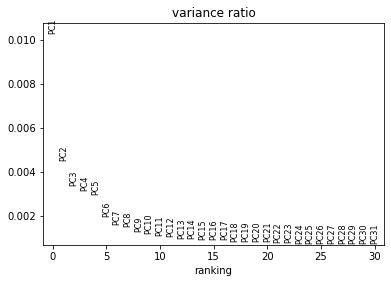

CPU times: user 6min 10s, sys: 11.3 s, total: 6min 22s
Wall time: 1min 25s


In [7]:
%%time
# Run PCA
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=False)

# Plot explained variance 
sc.pl.pca_variance_ratio(adata, log=False)

# Computing the neighborhood graph
n_neighbors = 50
n_pcs = 30
cluster_resolution = 1

sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(adata)

### UMAP

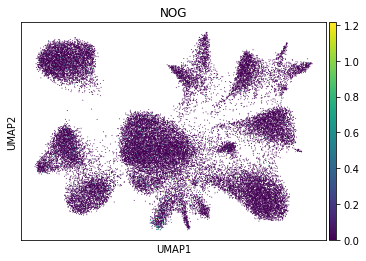

In [8]:
sc.pl.umap(adata, color='NOG')

In [ ]:
# Plot single meta UMAP
sc.pl.umap(adata, color='sample', save='_sample')
sc.pl.umap(adata, color='batch', save='_batch')
sc.pl.umap(adata, color='group', save='_group')
sc.pl.umap(adata, color='time', save='_time')

# Plot sample-wise UMAP
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    sc.pl.umap(adata, color='sample', groups=sample, save=f'_sample_{sample}')

# Plot group-wise UMAP
for group in sorted(adata.obs['group'].unique()):
    print(group)
    sc.pl.umap(adata, color='group', groups=group, save=f'_group_{group}')

# Save log
with open(f'./figures/log.txt', 'w') as f:
    f.write(f"""Number of neighbor: {n_neighbors}
Number of PC: {n_pcs}""")

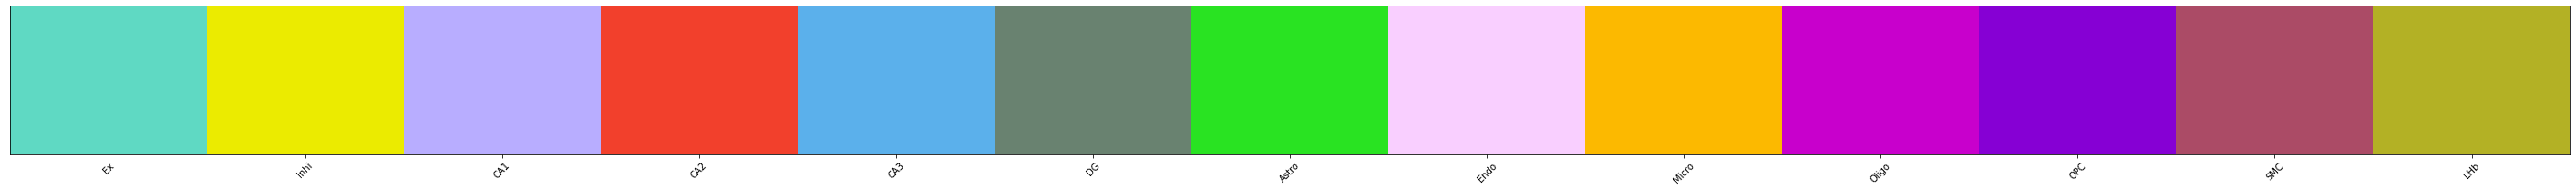

In [7]:
# Check color legend
top_cpl = []
for i in adata.uns['top_level_order']:
    top_cpl.append(adata.uns['top_rgb_dict'][i])

top_cpl = sns.color_palette(top_cpl)
top_cmap = ListedColormap(top_cpl.as_hex())
sns.palplot(top_cpl, size=3)
plt.xticks(range(len(adata.uns['top_level_order'])), adata.uns['top_level_order'], size=10, rotation=45)
plt.tight_layout()
plt.savefig(f'./figures/color_legend_top.png')
plt.show()

In [ ]:
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='top_level', frameon=False, 
           palette=top_cpl, save='_legend_side')

# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='top_level', legend_loc='on data',
           legend_fontsize=8, legend_fontoutline=2, frameon=False, 
           palette=top_cpl, save=True)

# Plot sample wise UMAP with top-level labels 
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    ax = sc.pl.umap(adata, show=False, size=(120000 / adata.n_obs))
    sc.pl.umap(adata[adata.obs["sample"] == sample], color='top_level', frameon=True, ax=ax, size=(120000 / adata.n_obs),
               palette=top_cpl, save=f'_{sample}')

# Plot group wise UMAP with top-level labels 
for group in sorted(adata.obs['group'].unique()):
    print(group)
    ax = sc.pl.umap(adata, show=False, size=(120000 / adata.n_obs))
    sc.pl.umap(adata[adata.obs["group"] == group], color='top_level', frameon=True, ax=ax, size=(120000 / adata.n_obs),
               palette=top_cpl, save=f'_{group}')

### Marker related 

In [ ]:
# Find gene markers for each cluster
sc.tl.rank_genes_groups(adata, 'top_level', method='wilcoxon')

# # Plot logFC heatmap
# sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, use_raw=False, swap_axes=True, 
#                                 vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True, values_to_plot='logfoldchanges',
#                                 dendrogram=False, figsize=(30, 15), save='_logFC')

# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save='_zscore')

# Plot z-score heatmap big
sc.pl.rank_genes_groups_heatmap(adata, n_genes=15, groupby='top_level', min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=False,
                                dendrogram=False, figsize=(30, 15), save='_zscore_big')

# Plot logFC dotplot
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, groupby='top_level', values_to_plot='logfoldchanges', min_logfoldchange=1, 
                                vmax=5, vmin=-5, cmap='bwr', save='logFC')

# Plot expression violin plot
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, 
                                       cmap='viridis_r', save='top')

# Plot expression violin plot
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, 
                                       cmap='viridis_r', dendrogram=False, save='top_noden')


# # Print markers 
# markers = []
# temp = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
# for i in range(temp.shape[1]):
#     curr_col = temp.iloc[:, i].to_list()
#     markers = markers + curr_col
#     print(curr_col)
    
# print(markers)
# plt.figure(figsize=(20,10))
# su.plot_heatmap_with_labels(adata, markers, 'leiden', use_labels=top_level_order,
#                             cmap=cluster_cmap, show_axis=True, font_size=10)
# plt.savefig('./figures/heatmap_top_v2.pdf')

### Composition bar plot

In [ ]:
# Composition Barplot 
n_cat = adata.obs['sample'].cat.categories.shape[0]
fig, ax = plt.subplots(n_cat, 1, figsize=(10,10))
fig.tight_layout()

for i, sample in enumerate(adata.obs['sample'].cat.categories):
    
    curr_cells = (adata.obs['sample'] == sample)
    temp = adata[curr_cells, :]

    cell_dist = pd.DataFrame(temp.obs['top_level'].value_counts())
    cell_dist['counts'] = cell_dist['top_level']
    cell_dist['top_level'] = cell_dist.index
    cell_dist['top_level'] = cell_dist['top_level'].astype(object)
    cell_dist = cell_dist.reset_index(drop=True)
    cell_dist = cell_dist.loc[cell_dist['counts'] != 0, :]
    cell_dist['top_level'] = cell_dist['top_level'].astype('category')
    cell_dist['top_level'] = cell_dist['top_level'].cat.reorder_categories(adata.uns['top_level_order'])


    g = sns.barplot(x='top_level', y='counts', data=cell_dist, palette=top_cpl, ax=ax[i]) 
    for index, sub in enumerate(cell_dist['top_level'].cat.categories):
        curr_position = round(cell_dist.loc[cell_dist['top_level'] == sub, 'counts'].values[0], 1)
        g.text(index, curr_position, curr_position, color='black', ha="center")

    for spine in ax[i].spines.values():
        spine.set_visible(False)
        
    ax[i].set_ylabel(sample, rotation=0, labelpad=50)
    # ax[i].set(ylim=(0, 1000))
    if i == n_cat-1:
        ax[i].get_xaxis().set_visible(True)
        ax[i].tick_params(top=False, bottom=True, left=False, right=False,
                          labeltop=False, labelleft=False, labelright=False, labelbottom=True)
    else:
        ax[i].get_xaxis().set_visible(False)
        ax[i].tick_params(top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelleft=False, labelright=False, labelbottom=False)
            
fig.suptitle(f'Top-level cell type count', y=1.03)  
plt.savefig('./figures/top_level_count_barplot.pdf', bbox_inches='tight')
plt.show()

### Spatial cell type map

In [13]:
# Spatial cell type map
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    su.plot_poly_cells_cluster_by_sample(adata, sample, top_cmap, show_plaque=True, show_tau=True, linewidth=0.5,
                                        figscale=3, width=10, height=10, save=True, show=False)

AD_mouse9494
AD_mouse9498
AD_mouse9723
AD_mouse9735


In [8]:
# Spatial cell type map
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    su.plot_poly_cells_cluster_by_sample(adata, sample, top_cmap, show_plaque=True, show_tau=True, 
                                         save_as_real_size=True, linewidth=0.5,
                                        figscale=3, width=10, height=10, save=True, show=False)

AD_mouse9494
AD_mouse9498
AD_mouse9723
AD_mouse9735


## Sub-level

In [18]:
# Subset
sub_id = 'Inh'
curr_cells = adata.obs['top_level'] == sub_id
sdata = adata[curr_cells, :]
sdata

View of AnnData object with n_obs × n_vars = 2005 × 2112
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'top_level', 'cell_type', 'region', 'cell_type_label'
    var: 'max_counts', 'detected', 'mean', 'std'
    uns: 'AD_mouse9494_morph', 'AD_mouse9498_morph', 'AD_mouse9723_morph', 'AD_mouse9735_morph', 'cell_type_label_order', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict'
    layers: 'corrected', 'scaled'

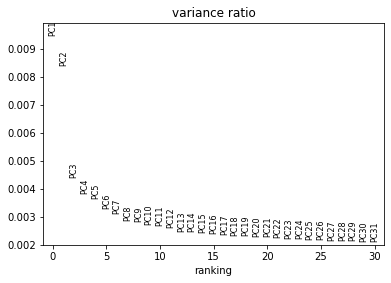

CPU times: user 13.1 s, sys: 1.08 s, total: 14.2 s
Wall time: 4.94 s


In [49]:
%%time
# Run PCA
sc.tl.pca(sdata, svd_solver='arpack')

# Plot explained variance 
sc.pl.pca_variance_ratio(sdata, log=False)

# Computing the neighborhood graph
n_neighbors = 30
n_pcs = 15
cluster_resolution = .4


sc.pp.neighbors(sdata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(sdata)

### UMAP

Consider running `set_figure_params(dpi_save=...)`, which will adjust `matplotlib.rcParams['savefig.dpi']`


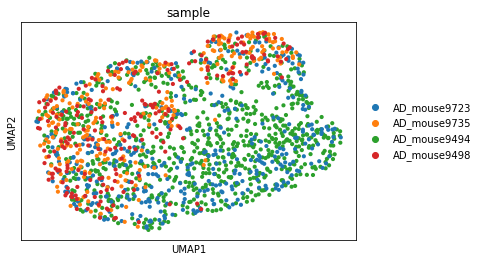

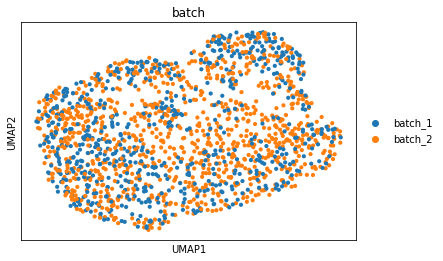

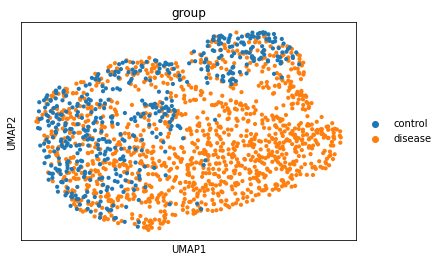

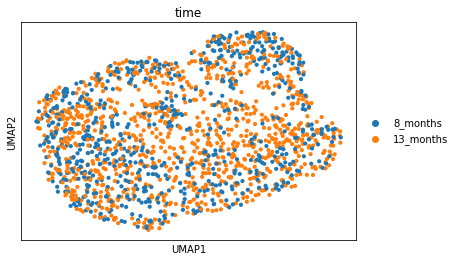

AD_mouse9494


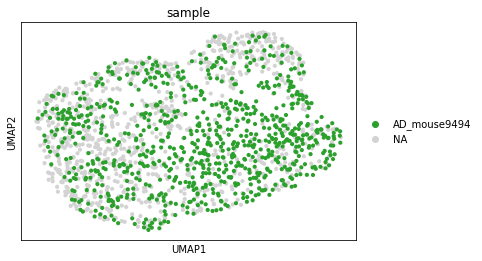

AD_mouse9498


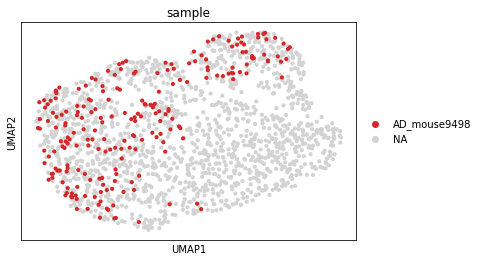

AD_mouse9723


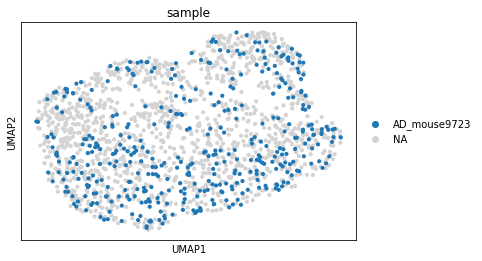

AD_mouse9735


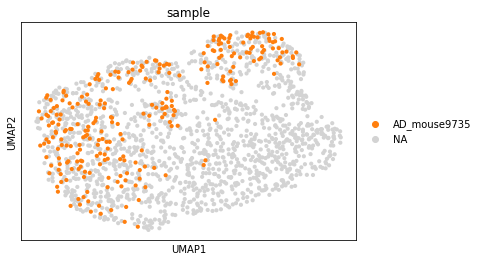

control


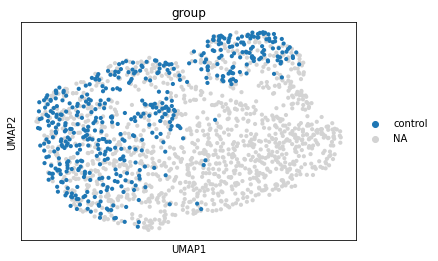

disease


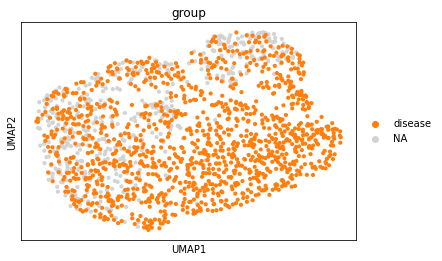

In [9]:
# Plot UMAP
sc.pl.umap(sdata, color='sample', save='_sample')
sc.pl.umap(sdata, color='batch', save='_batch')
sc.pl.umap(sdata, color='group', save='_group')
sc.pl.umap(sdata, color='time', save='_time')

# Plot sample-wise UMAP
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    sc.pl.umap(sdata, color='sample', groups=sample, save=f'_sample_{sample}')

# Plot group-wise UMAP
for group in sorted(sdata.obs['group'].unique()):
    print(group)
    sc.pl.umap(sdata, color='group', groups=group, save=f'_group_{group}')


# Save log
with open(f'./figures/log.txt', 'w') as f:
    f.write(f"""Number of neighbor: {n_neighbors}
Number of PC: {n_pcs}""")

In [10]:
sdata

View of AnnData object with n_obs × n_vars = 2005 × 2112
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'top_level', 'cell_type', 'region', 'cell_type_label'
    var: 'max_counts', 'detected', 'mean', 'std'
    uns: 'AD_mouse9494_morph', 'AD_mouse9498_morph', 'AD_mouse9723_morph', 'AD_mouse9735_morph', 'cell_type_label_order', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict'
    layers: 'corrected', 'scaled'

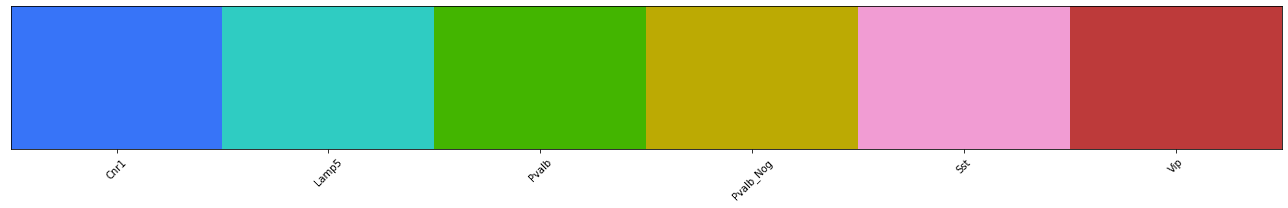

In [19]:
new_color = False

# Check color legend
curr_cell_type = [] 
for cell_type in sdata.uns['cell_type_order']:
    if cell_type in sdata.obs['cell_type'].unique():
        curr_cell_type.append(cell_type)

sub_cpl = []
for i in curr_cell_type:
    if '/' in i:
        curr_key = i.split('/')
        sub_cpl.append(sdata.uns['sub_rgb_dict'][curr_key[0]][curr_key[1]])
    else:       
        sub_cpl.append(sdata.uns['sub_rgb_dict'][i])

if new_color:
    sub_cpl = ['#2fe04d', '#2c73e6', '#fa733e']
sub_cpl = sns.color_palette(sub_cpl)
sub_cmap = ListedColormap(sub_cpl.as_hex())
sns.palplot(sub_cpl, size=3)
plt.xticks(range(len(curr_cell_type)), curr_cell_type, size=10, rotation=45)
plt.tight_layout()
plt.savefig(f'./figures/color_legend_{sub_id}.png')
plt.show()

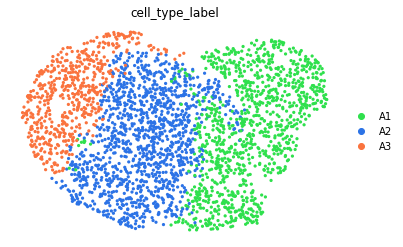

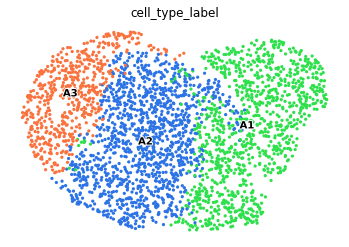

Trying to set attribute `.uns` of view, copying.


AD_mouse9494


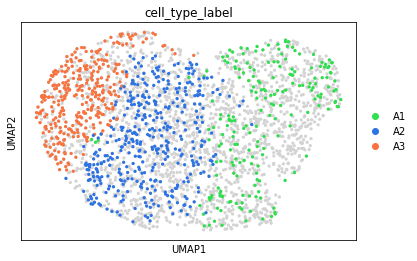

Trying to set attribute `.uns` of view, copying.


AD_mouse9498


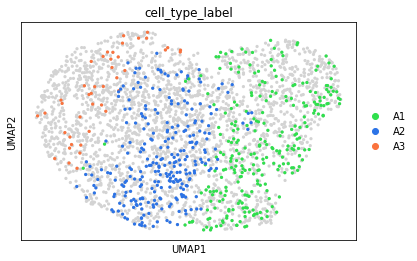

Trying to set attribute `.uns` of view, copying.


AD_mouse9723


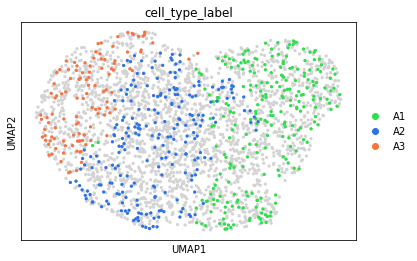

Trying to set attribute `.uns` of view, copying.


AD_mouse9735


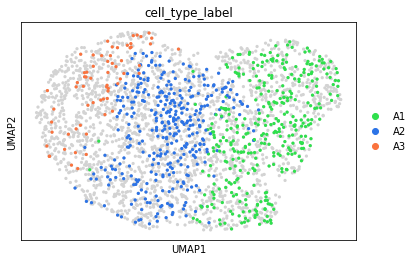

Trying to set attribute `.uns` of view, copying.


control


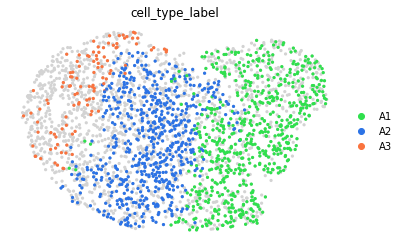

Trying to set attribute `.uns` of view, copying.


disease


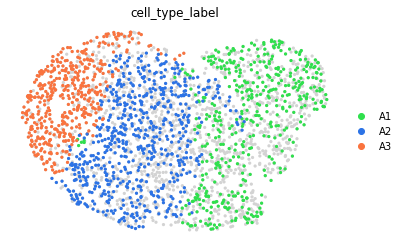

In [39]:
# UMAP cell type label
sc.pl.umap(sdata, color='cell_type_label', frameon=False, 
           palette=sub_cpl, save=f'_label_legend_side')

# Save plots (cell_type_label)
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(sdata, color='cell_type_label', legend_loc='on data',
           legend_fontsize=10, legend_fontoutline=2, frameon=False, 
           palette=sub_cpl, save=f'_label')

# Plot sample wise UMAP with sub-level labels 
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    ax = sc.pl.umap(sdata, show=False, size=(120000 / sdata.n_obs))
    sc.pl.umap(sdata[sdata.obs["sample"] == sample], color='cell_type_label', frameon=True, ax=ax, size=(120000 / sdata.n_obs),
               palette=sub_cpl, save=f'_label_{sample}')

# Plot group wise UMAP with sub-level labels 
for group in sorted(sdata.obs['group'].unique()):
    print(group)
    ax = sc.pl.umap(sdata, show=False, size=(120000 / sdata.n_obs))
    sc.pl.umap(sdata[sdata.obs["group"] == group], color='cell_type_label', frameon=False, ax=ax, size=(120000 / sdata.n_obs),
               palette=sub_cpl, save=f'_label_{group}')


In [70]:
sub_id = 'OPC_Oligo'

In [8]:
# Pseudotime 

# load pseudotime file 
time_df = pd.read_csv(f'./pseudotime/AD_{sub_id}_pseudotime.csv')
time_df 

orig_index        sample   area   tau     x     y    batch       time  \
0              2  AD_mouse9494   5732  0.00   905     5  batch_2  13_months   
1              9  AD_mouse9494   8115  0.00   983     9  batch_2  13_months   
2             16  AD_mouse9494   8180  0.00  1166    13  batch_2  13_months   
3             18  AD_mouse9494   6835  0.00   934    12  batch_2  13_months   
4             24  AD_mouse9494   8783  0.00  1032    13  batch_2  13_months   
...          ...           ...    ...   ...   ...   ...      ...        ...   
4372        7788  AD_mouse9498  11430  0.00  2589  6289  batch_2  13_months   
4373        7791  AD_mouse9498   9364  0.00  2532  6288  batch_2  13_months   
4374        7793  AD_mouse9498  10085  0.00  2502  6292  batch_2  13_months   
4375        7795  AD_mouse9498   7525  0.28  2476  6295  batch_2  13_months   
4376        7799  AD_mouse9498  10201  0.00  2557  6300  batch_2  13_months   

        group  n_genes_by_counts  ...  X__is_in_cluster__  top_level  \
0     disease                133  ...               False         DG   
1     disease                187  ...               False         DG   
2     disease                152  ...               False         DG   
3     disease                159  ...               False         DG   
4     disease                190  ...               False         DG   
...       ...                ...  ...                 ...        ...   
4372  control                179  ...               False         DG   
4373  control                162  ...               False         DG   
4374  control                202  ...               False         DG   
4375  control                125  ...               False         DG   
4376  control                172  ...               False         DG   

      cell_type       region  cell_type_label  nCount_RNA  nFeature_RNA  \
0            DG  Hippocampus               DG         144           127   
1            DG  Hippocampus               DG         218           178   
2            DG  Hippocampus               DG         179           146   
3            DG  Hippocampus               DG         184           148   
4            DG  Hippocampus               DG         222           183   
...         ...          ...              ...         ...           ...   
4372         DG  Hippocampus               DG         229           170   
4373         DG  Hippocampus               DG         196           160   
4374         DG  Hippocampus               DG         251           196   
4375         DG  Hippocampus               DG         148           120   
4376         DG  Hippocampus               DG         218           166   

     pseudotime     UMAP1     UMAP2  
0      6.102045  0.289388 -2.175504  
1      0.909031  0.175566  2.231232  
2      0.000164 -4.334595  2.633090  
3      0.000163 -3.743376  1.598179  
4      0.000162 -2.640702  2.630088  
...         ...       ...       ...  
4372   4.077504  3.168296  1.637930  
4373   9.600844 -3.701831  0.018355  
4374   4.077505  1.936142  2.183906  
4375   5.426702  2.755095 -1.217987  
4376   6.037819  1.962585 -1.481045  

[4377 rows x 26 columns]

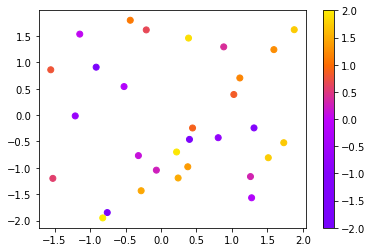

In [9]:
# Test customized linear colormap
# test = ["#33db27", "#f0f029", '#ed5d28']
# test = ["#2997ff", "#33db27", "#f0f029", '#ed5d28']
# test = ["#7703fc", "#8403fc", "#be03fc", "#fc6b03", '#fceb03']
test = ["#7703fc", "#8403fc", "#be03fc", "#fc6b03", '#fceb03'] # try blue to red 
x,y,c = zip(*np.random.rand(30,3)*4-2)

norm=plt.Normalize(-2,2)
cmap = LinearSegmentedColormap.from_list("", test)

plt.scatter(x,y,c=c, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

In [14]:
# OR use preset colormap
cmap = sns.color_palette('plasma', as_cmap=True)

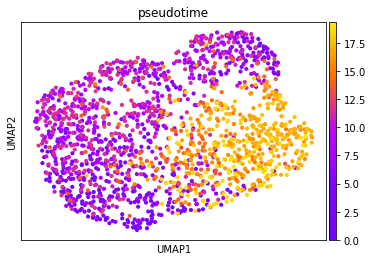

In [45]:
sdata.obs['pseudotime'] = time_df['pseudotime'].values
sc.pl.umap(sdata, color='pseudotime', frameon=True, size=(120000 / sdata.n_obs),
               color_map=cmap)

AD_mouse9494


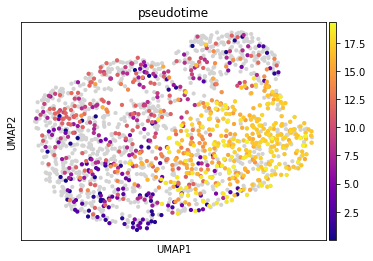

AD_mouse9498


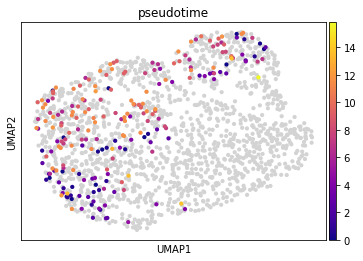

AD_mouse9723


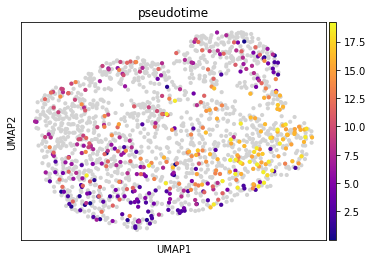

AD_mouse9735


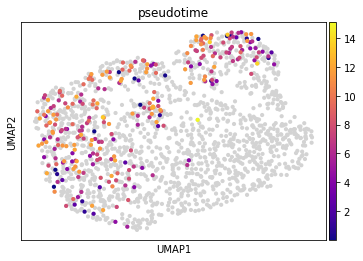

In [15]:
sdata.obs['pseudotime'] = time_df['pseudotime'].values

# Plot sample wise UMAP with sub-level labels 
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    ax = sc.pl.umap(sdata, show=False, size=(120000 / sdata.n_obs))
    sc.pl.umap(sdata[sdata.obs["sample"] == sample], color='pseudotime', frameon=True, ax=ax, size=(120000 / sdata.n_obs),
               color_map=cmap)


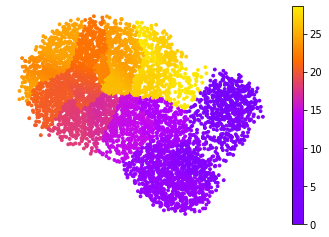

In [72]:
# Use monocle embedding 
plt.scatter(time_df['UMAP1'], time_df['UMAP2'], c=time_df['pseudotime'], cmap=cmap, s=8)
plt.colorbar()
plt.axis('off')
plt.savefig(f'figures/umap_trajectory_{sub_id}.pdf')
plt.show()

AD_mouse9494


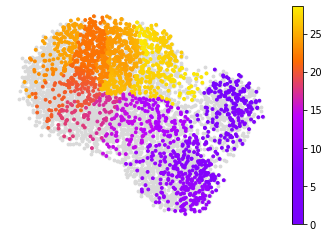

AD_mouse9498


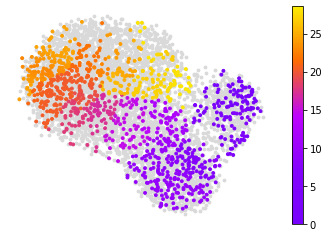

AD_mouse9723


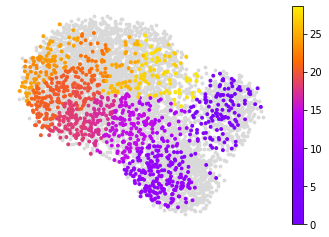

AD_mouse9735


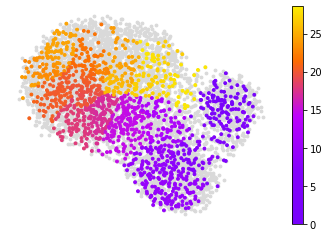

In [73]:
vmin = time_df['pseudotime'].min()
vmax = time_df['pseudotime'].max()

for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    current_df = time_df.loc[time_df['sample'] == sample, :]
    plt.scatter(time_df['UMAP1'], time_df['UMAP2'], 
            c='#D9D9D9', s=8)
    plt.scatter(current_df['UMAP1'], current_df['UMAP2'], c=current_df['pseudotime'], 
                cmap=cmap, s=8, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.axis('off')
    plt.savefig(f'figures/umap_trajectory_{sub_id}_{sample}.pdf')
    plt.show()

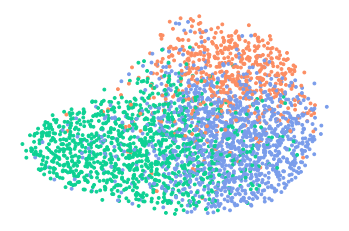

In [288]:
# Subtype label on monocle embedding

# Use monocle embedding 
current_colors = time_df['cell_type_label'].astype('category').cat.codes.values
plt.scatter(time_df['UMAP1'], time_df['UMAP2'], c=current_colors, cmap=sub_cmap, s=8)
plt.axis('off')
plt.savefig(f'figures/umap_trajectory_{sub_id}_with_subtype.pdf')
plt.show()

AD_mouse9494


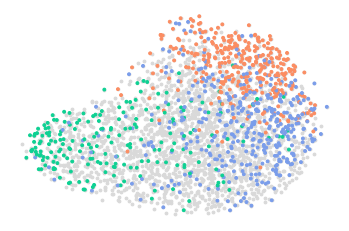

AD_mouse9498


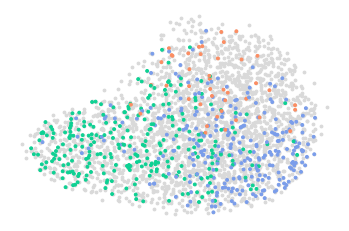

AD_mouse9723


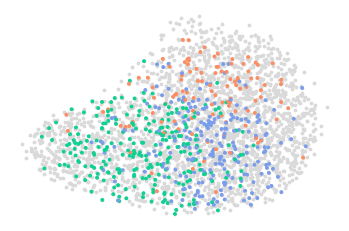

AD_mouse9735


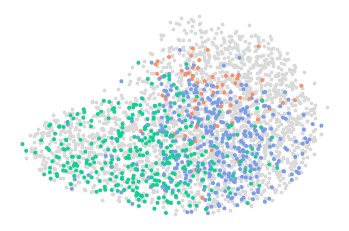

In [289]:
# Subtype label on monocle embedding per sample

for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    current_df = time_df.loc[time_df['sample'] == sample, :]
    current_colors = current_df['cell_type_label'].astype('category').cat.codes.values
    plt.scatter(time_df['UMAP1'], time_df['UMAP2'], 
            c='#D9D9D9', s=8)
    plt.scatter(current_df['UMAP1'], current_df['UMAP2'], c=current_colors, 
                cmap=sub_cmap, s=8)
    plt.axis('off')
    plt.savefig(f'figures/umap_trajectory_{sub_id}_{sample}_with_subtype.pdf')
    plt.show()

### Marker related

In [ ]:
# Find gene markers for each cluster
sc.tl.rank_genes_groups(sdata, 'cell_type', method='wilcoxon')

min_logfoldchange = .5
# Plot logFC heatmap
sc.pl.rank_genes_groups_heatmap(sdata, n_genes=5, groupby='cell_type', min_logfoldchange=min_logfoldchange, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True, values_to_plot='logfoldchanges',
                                dendrogram=False, figsize=(30, 15), save='_logFC')

# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(sdata, n_genes=5, groupby='cell_type', min_logfoldchange=min_logfoldchange, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save='_zscore')

# Plot logFC dotplot
sc.pl.rank_genes_groups_dotplot(sdata, n_genes=5, groupby='cell_type', values_to_plot='logfoldchanges', min_logfoldchange=min_logfoldchange, 
                                vmax=5, vmin=-5, cmap='bwr', save='logFC')

# Plot expression violin plot
sc.pl.rank_genes_groups_stacked_violin(sdata, n_genes=5, groupby='cell_type', min_logfoldchange=min_logfoldchange, 
                                       cmap='viridis_r', save=sub_id)

# Plot expression violin plot
sc.pl.rank_genes_groups_stacked_violin(sdata, n_genes=5, groupby='cell_type', min_logfoldchange=min_logfoldchange, 
                                       cmap='viridis_r', dendrogram=False, save=f'{sub_id}_noden')

# Plot expression matrix plot
sc.pl.rank_genes_groups_matrixplot(sdata, n_genes=5, use_raw=False, vmin=-5, vmax=5, cmap='bwr', layer='scaled',
                                  dendrogram=False, min_logfoldchange=min_logfoldchange, save=sub_id)

# Print markers 
markers = []
temp = pd.DataFrame(sdata.uns['rank_genes_groups']['names']).head(2)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)
    
# print(markers)
# plt.figure(figsize=(20,10))
# su.plot_heatmap_with_labels(adata, markers, 'leiden', use_labels=top_level_order,
#                             cmap=cluster_cmap, show_axis=True, font_size=10)
# plt.savefig('./figures/heatmap_top_v2.pdf')

In [ ]:
# Marker Barplot 
# markers = markers[0:4]
n_markers = len(markers)
fig, ax = plt.subplots(n_markers, 1, figsize=(5,10))
fig.tight_layout()

for i, gene in enumerate(markers):
    expr = sdata.raw[:, gene].X.flatten()
    cluster = sdata.obs['cell_type']
    curr_df = pd.DataFrame({'cluster': cluster, 'expr': expr})
    # print(curr_df)
    sns.barplot(x="cluster", y="expr", data=curr_df, ax=ax[i], capsize=.2, errwidth=1, palette=sub_cpl)
    for spine in ax[i].spines.values():
        spine.set_visible(False)
        
    change_width(ax[i], .35)
    ax[i].set_ylabel(markers[i], rotation=0, labelpad=20)
    ax[i].set(ylim=(0, 1.5))
    ax[i].tick_params(axis='x', rotation=45)
    if i == n_markers-1:
        ax[i].get_xaxis().set_visible(True)
        ax[i].tick_params(top=False, bottom=True, left=False, right=True,
                          labeltop=False, labelleft=False, labelright=True, labelbottom=True)
    else:
        ax[i].get_xaxis().set_visible(False)
        ax[i].tick_params(top=False, bottom=False, left=False, right=True,
                          labeltop=False, labelleft=False, labelright=True, labelbottom=False)
 
fig.suptitle(f'{sub_id} marker gene expression', y=1.03) 
plt.savefig('./figures/marker_barplot.pdf', bbox_inches='tight')
plt.show()

### Composition bar plot 

In [ ]:
# Composition Barplot 
sample_tags = ['Control (8 months)', 'Disease (8 months)', 'Control (13 months)', 'Disease (13 months)']

cell_dist_list = []
for i, sample in enumerate(sdata.obs['sample'].cat.categories):
    
    curr_cells = (sdata.obs['sample'] == sample)
    temp = sdata[curr_cells, :]

    cell_dist = pd.DataFrame(temp.obs['cell_type_label'].value_counts())
    cell_dist['counts'] = cell_dist['cell_type_label']
    cell_dist['cell_type_label'] = cell_dist.index
    cell_dist['cell_type_label'] = cell_dist['cell_type_label'].astype(object)
    cell_dist = cell_dist.reset_index(drop=True)
    # cell_dist = cell_dist.loc[cell_dist['counts'] != 0, :]
    # cell_dist['cell_type'] = cell_dist['cell_type'].astype('category')
    
#     for j in curr_cell_type:
#         if j not in cell_dist['cell_type_label'].unique():
#             cell_dist = cell_dist.append({'cell_type_label': j, 'counts': 0}, ignore_index=True)
    
    cell_dist['cell_type_label'] = cell_dist['cell_type_label'].astype('category')
    # cell_dist['cell_type_label'] = cell_dist['cell_type_label'].cat.reorder_categories(curr_cell_type)
    cell_dist['sample'] = sample_tags[i]
    cell_dist_list.append(cell_dist)


In [ ]:
cell_dist_total = pd.concat(cell_dist_list)

fig, ax = plt.subplots(figsize=(7,7))
ax = sns.barplot(x="cell_type_label", y="counts", hue="sample", data=cell_dist_total, ax=ax)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.setp(ax.patches, linewidth=1, edgecolor='black')
plt.savefig(f'./figures/{sub_id}_composition.pdf')

In [ ]:
# Composition Barplot 
n_cat = sdata.obs['sample'].cat.categories.shape[0]
fig, ax = plt.subplots(n_cat, 1, figsize=(5,10))
fig.tight_layout()

for i, sample in enumerate(sdata.obs['sample'].cat.categories):
    
    curr_cells = (sdata.obs['sample'] == sample)
    temp = sdata[curr_cells, :]

    cell_dist = pd.DataFrame(temp.obs['cell_type'].value_counts())
    cell_dist['counts'] = cell_dist['cell_type']
    cell_dist['cell_type'] = cell_dist.index
    cell_dist['cell_type'] = cell_dist['cell_type'].astype(object)
    cell_dist = cell_dist.reset_index(drop=True)
    cell_dist = cell_dist.loc[cell_dist['counts'] != 0, :]
    # cell_dist['cell_type'] = cell_dist['cell_type'].astype('category')
    
    for j in curr_cell_type:
        if j not in cell_dist['cell_type'].unique():
            cell_dist = cell_dist.append({'cell_type': j, 'counts': 0}, ignore_index=True)
    
    cell_dist['cell_type'] = cell_dist['cell_type'].astype('category')
    cell_dist['cell_type'] = cell_dist['cell_type'].cat.reorder_categories(curr_cell_type)


    g = sns.barplot(x='cell_type', y='counts', data=cell_dist, palette=sub_cpl, ax=ax[i]) 
    for index, sub in enumerate(cell_dist['cell_type'].cat.categories):
        curr_position = round(cell_dist.loc[cell_dist['cell_type'] == sub, 'counts'].values[0], 1)
        g.text(index, curr_position, curr_position, color='black', ha="center")

    for spine in ax[i].spines.values():
        spine.set_visible(False)
    
    change_width(ax[i], .35)
    ax[i].set_ylabel(sample, rotation=0, labelpad=50)
    ax[i].set(ylim=(0, 1000))
    ax[i].tick_params(axis='x', rotation=45)
    if i == n_cat-1:
        ax[i].get_xaxis().set_visible(True)
        ax[i].tick_params(top=False, bottom=True, left=False, right=False,
                          labeltop=False, labelleft=False, labelright=False, labelbottom=True)
    else:
        ax[i].get_xaxis().set_visible(False)
        ax[i].tick_params(top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelleft=False, labelright=False, labelbottom=False)
            
            
fig.suptitle(f'{sub_id} cell type count', y=1.03) 
fig.savefig('./figures/cell_type_count_barplot.pdf', bbox_inches='tight')
plt.show()

### Composition Pie chart

In [ ]:
# pie chart

for i, sample in enumerate(sdata.obs['sample'].cat.categories):
    
    curr_cells = (sdata.obs['sample'] == sample)
    temp = sdata[curr_cells, :]

    cell_dist = pd.DataFrame(temp.obs['leiden'].value_counts())
    cell_dist['counts'] = cell_dist['leiden']
    cell_dist['leiden'] = cell_dist.index
    cell_dist['leiden'] = cell_dist['leiden'].astype(object)
    cell_dist = cell_dist.reset_index(drop=True)
    cell_dist = cell_dist.loc[cell_dist['counts'] != 0, :]
    # cell_dist['cell_type'] = cell_dist['cell_type'].astype('category')
    
    for j in curr_cell_type:
        if j not in cell_dist['leiden'].unique():
            cell_dist = cell_dist.append({'leiden': j, 'counts': 0}, ignore_index=True)
    
    cell_dist['leiden'] = cell_dist['leiden'].astype('category')
    #cell_dist['leiden'] = cell_dist['leiden'].cat.reorder_categories(curr_cell_type)
    
    n_cells = cell_dist['counts'].sum()
    cell_dist['counts'] = cell_dist['counts'].div(cell_dist['counts'].sum(axis=0), axis=0).multiply(100)
    cell_dist = cell_dist.loc[cell_dist['counts'] != 0, :]
    
#     sub_cpl = []
#     for i in cell_dist['cell_type']:
#         if '/' in i:
#             curr_key = i.split('/')
#             sub_cpl.append(sdata.uns['sub_rgb_dict'][curr_key[0]][curr_key[1]])
#         else:       
#             sub_cpl.append(sdata.uns['sub_rgb_dict'][i])

#     sub_cpl = sns.color_palette(sub_cpl)

    fig, ax = plt.subplots(figsize=(10,10))
    _, _, autopcts = ax.pie(cell_dist['counts'], labels=cell_dist['leiden'], autopct='%1.1f%%', colors=sub_cpl,
          textprops={'size': 15, 'weight':'bold'})
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f"{sample} - Number of cells: {n_cells}", fontsize=15, weight='bold', y=1.05)
    plt.setp(autopcts, **{'color':'black', 'weight':'bold', 'fontsize':12.5})
    plt.tight_layout()
    #plt.savefig(f'./figures/{sample}_{sub_id}_pie_{region_type}.pdf', bbox_inches='tight')
    plt.show()

### Spatial cell type map

In [20]:
# Spatial cell type 
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    current_key = f"{sample}_morph"
    current_index = sdata.obs['sample'] == sample
    # change to new color 
    sdata.uns[current_key]['colors'] = sdata.obs.loc[current_index, 'cell_type'].cat.codes.values
    sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
    
    su.plot_poly_cells_cluster_by_sample(sdata, sample, sub_cmap, show_plaque=True, show_tau=True,
                                         save_as_real_size=True, linewidth=0.5,
                                        figscale=3, width=10, height=10, save=True, show=False)

AD_mouse9494
AD_mouse9498
AD_mouse9723
AD_mouse9735


## Others

### Spatial map of gene expression

In [ ]:
curr_gene = 'CPLX1'
# subset_type = 'Oligo'
subset_type = None

cmap = sns.color_palette('viridis', as_cmap=True)
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    current_key = f"{sample}_morph"
    
    if subset_type is not None:
        current_index = adata.obs['top_level'] == subset_type
        sdata = adata[current_index, :]
    else:
        sdata = adata

    current_index = sdata.obs['sample'] == sample
    sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
        
    su.plot_poly_cells_expr_by_sample(sdata, sample, curr_gene, cmap, use_raw=False,
                                      figscale=30, width=10, height=10,
                                      show_plaque=True, show_tau=True, show_tau_cells=False,
                                      show=False, save=f'{curr_gene}_z')

### Spatial map of pseudotime

In [10]:
curr_cells = adata.obs['top_level'].isin(['DG'])
sdata = adata[curr_cells, :]

In [11]:
# load pseudotime file 
time_df = pd.read_csv(f'./pseudotime/AD_{sub_id}_pseudotime.csv')
time_df 

orig_index        sample   area   tau     x     y    batch       time  \
0              2  AD_mouse9494   5732  0.00   905     5  batch_2  13_months   
1              9  AD_mouse9494   8115  0.00   983     9  batch_2  13_months   
2             16  AD_mouse9494   8180  0.00  1166    13  batch_2  13_months   
3             18  AD_mouse9494   6835  0.00   934    12  batch_2  13_months   
4             24  AD_mouse9494   8783  0.00  1032    13  batch_2  13_months   
...          ...           ...    ...   ...   ...   ...      ...        ...   
4372        7788  AD_mouse9498  11430  0.00  2589  6289  batch_2  13_months   
4373        7791  AD_mouse9498   9364  0.00  2532  6288  batch_2  13_months   
4374        7793  AD_mouse9498  10085  0.00  2502  6292  batch_2  13_months   
4375        7795  AD_mouse9498   7525  0.28  2476  6295  batch_2  13_months   
4376        7799  AD_mouse9498  10201  0.00  2557  6300  batch_2  13_months   

        group  n_genes_by_counts  ...  X__is_in_cluster__  top_level  \
0     disease                133  ...               False         DG   
1     disease                187  ...               False         DG   
2     disease                152  ...               False         DG   
3     disease                159  ...               False         DG   
4     disease                190  ...               False         DG   
...       ...                ...  ...                 ...        ...   
4372  control                179  ...               False         DG   
4373  control                162  ...               False         DG   
4374  control                202  ...               False         DG   
4375  control                125  ...               False         DG   
4376  control                172  ...               False         DG   

      cell_type       region  cell_type_label  nCount_RNA  nFeature_RNA  \
0            DG  Hippocampus               DG         144           127   
1            DG  Hippocampus               DG         218           178   
2            DG  Hippocampus               DG         179           146   
3            DG  Hippocampus               DG         184           148   
4            DG  Hippocampus               DG         222           183   
...         ...          ...              ...         ...           ...   
4372         DG  Hippocampus               DG         229           170   
4373         DG  Hippocampus               DG         196           160   
4374         DG  Hippocampus               DG         251           196   
4375         DG  Hippocampus               DG         148           120   
4376         DG  Hippocampus               DG         218           166   

     pseudotime     UMAP1     UMAP2  
0      6.102045  0.289388 -2.175504  
1      0.909031  0.175566  2.231232  
2      0.000164 -4.334595  2.633090  
3      0.000163 -3.743376  1.598179  
4      0.000162 -2.640702  2.630088  
...         ...       ...       ...  
4372   4.077504  3.168296  1.637930  
4373   9.600844 -3.701831  0.018355  
4374   4.077505  1.936142  2.183906  
4375   5.426702  2.755095 -1.217987  
4376   6.037819  1.962585 -1.481045  

[4377 rows x 26 columns]

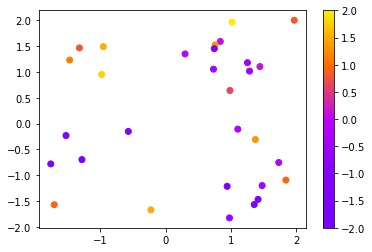

In [12]:
# Test customized linear colormap
# test = ["#33db27", "#f0f029", '#ed5d28']
# test = ["#2997ff", "#33db27", "#f0f029", '#ed5d28']
test = ["#7703fc", "#8403fc", "#be03fc", "#fc6b03", '#fceb03']
x,y,c = zip(*np.random.rand(30,3)*4-2)

norm=plt.Normalize(-2,2)
cmap = LinearSegmentedColormap.from_list("", test)

plt.scatter(x,y,c=c, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

In [ ]:
# # OR use preset colormap
# cmap = sns.color_palette('plasma', as_cmap=True)

In [13]:
meta_df = time_df
current_meta = 'pseudotime'
# subset_type = ['Micro']

vmin = meta_df[current_meta].min()
vmax = meta_df[current_meta].max()

for sample in sorted(adata.obs['sample'].unique()):
    print(sample)

    current_meta_df = meta_df.loc[meta_df['sample'] == sample, :]

    current_orig_index = current_meta_df['orig_index'].astype(str)
    
    sdata = adata[adata.obs['sample'] == sample, :]
    current_index = sdata.obs['orig_index'].astype(str).isin(current_orig_index)
    sdata = sdata[current_index, :]
    sdata.obs[current_meta] = current_meta_df[current_meta].values

    current_key = f"{sample}_morph"
    sdata.uns[current_key]['good_cells'] = sdata.obs['orig_index'].astype(int).values

    su.plot_poly_cells_meta_by_sample(sdata, sample, current_meta, cmap, use_raw=True, figscale=3,
                                      save_as_real_size=True, linewidth=0.5, vmin=vmin, vmax=vmax,
                                      show_plaque=True, show_tau=True, show_colorbar=False,
                                      show=False, save=current_meta)

Trying to set attribute `.obs` of view, copying.


AD_mouse9494
0.0 12.45580819216088


Trying to set attribute `.obs` of view, copying.


AD_mouse9498
0.0 12.45580819216088


Trying to set attribute `.obs` of view, copying.


AD_mouse9723
0.0 12.45580819216088


Trying to set attribute `.obs` of view, copying.


AD_mouse9735
0.0 12.45580819216088


### Sample pseudotime distribution

In [7]:
# load pseudotime file 
sub_id = "Micro"
time_df = pd.read_csv(f'./pseudotime/AD_{sub_id}_pseudotime.csv')
time_df 

orig_index        sample  area  tau     x     y    batch       time  \
0             13  AD_mouse9494  5765  0.0  3826     8  batch_2  13_months   
1             42  AD_mouse9494  9402  0.0  2317    31  batch_2  13_months   
2             45  AD_mouse9494  7073  0.0  1292    34  batch_2  13_months   
3             51  AD_mouse9494  7603  0.0  2178    37  batch_2  13_months   
4             53  AD_mouse9494  9387  0.0   885    35  batch_2  13_months   
...          ...           ...   ...  ...   ...   ...      ...        ...   
1718        7991  AD_mouse9498  8271  0.0  5627  6530  batch_2  13_months   
1719        8020  AD_mouse9498  6752  0.0  1209  6549  batch_2  13_months   
1720        8117  AD_mouse9498  6811  0.0  4117  6625  batch_2  13_months   
1721        8136  AD_mouse9498  9350  0.0  3953  6639  batch_2  13_months   
1722        8165  AD_mouse9498  6374  0.0  4287  6655  batch_2  13_months   

        group  n_genes_by_counts  ...  X__is_in_cluster__  top_level  \
0     disease                 90  ...               False      Micro   
1     disease                135  ...               False      Micro   
2     disease                102  ...               False      Micro   
3     disease                 89  ...               False      Micro   
4     disease                172  ...               False      Micro   
...       ...                ...  ...                 ...        ...   
1718  control                120  ...               False      Micro   
1719  control                 95  ...               False      Micro   
1720  control                101  ...               False      Micro   
1721  control                100  ...               False      Micro   
1722  control                 53  ...               False      Micro   

            cell_type       region  cell_type_label  nCount_RNA  nFeature_RNA  \
0     Micro_Cst7/Ctsb  Hippocampus               M3         109            87   
1         Micro_Gpr34  Hippocampus               M2         169           128   
2         Micro_Gpr34  Hippocampus               M2         106            95   
3     Micro_Cst7/Ctsb  Hippocampus               M3         111            83   
4         Micro_Gpr34  Hippocampus               M2         188           159   
...               ...          ...              ...         ...           ...   
1718            Micro  Hippocampus               M1         132           113   
1719      Micro_Gpr34  Hippocampus               M2         104            93   
1720            Micro  Hippocampus               M1         111            93   
1721            Micro  Hippocampus               M1         111            91   
1722      Micro_Gpr34  Hippocampus               M2          68            51   

     pseudotime     UMAP1     UMAP2  
0     11.938498 -1.016800  0.815882  
1     16.923545 -4.412405 -1.738135  
2     18.651894 -2.404822 -2.965408  
3     16.975059 -3.537116 -2.384354  
4      0.501767  4.437535  0.198064  
...         ...       ...       ...  
1718  13.079931 -2.110824  1.271107  
1719  11.380684 -1.551972  2.806060  
1720  11.887461 -0.855873  0.926867  
1721   4.192917  0.755105 -2.210421  
1722   7.784228  0.362926 -0.257075  

[1723 rows x 26 columns]

In [8]:
# Set category order 
time_df['sample'] = time_df['sample'].astype('category')
time_df['sample'] = time_df['sample'].cat.reorder_categories(['AD_mouse9735', 'AD_mouse9723', 'AD_mouse9498', 'AD_mouse9494'])

time_df['cell_type_label'] = time_df['cell_type_label'].astype('category')

# Normalize pseudotime 
time_df['pseudotime'] = time_df['pseudotime'] / time_df['pseudotime'].max()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

AD_mouse9735 v.s. AD_mouse9723: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.371e-05 U_stat=4.514e+04
AD_mouse9498 v.s. AD_mouse9494: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.524e-33 U_stat=4.235e+04
AD_mouse9723 v.s. AD_mouse9494: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.114e-12 U_stat=1.270e+05


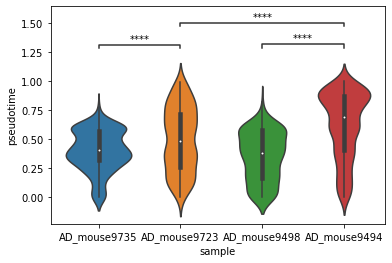

In [9]:
fig, ax = plt.subplots()
sns.violinplot(x='sample', y='pseudotime', data=time_df, ax=ax)
add_stat_annotation(ax, x='sample', y='pseudotime', data=time_df,
                    box_pairs=[("AD_mouse9735", "AD_mouse9723"), ("AD_mouse9498", "AD_mouse9494"), ("AD_mouse9723", "AD_mouse9494")],
                    test='Mann-Whitney', text_format='star', verbose=2, line_offset_to_box=.2)
plt.savefig(f'figures/{sub_id}_pseudotime_distribution_sample.pdf')
plt.show()

### Subtype pseudotime distribution

In [3]:
# load pseudotime file 
sub_id = "Micro" # OPC_Oligo
time_df = pd.read_csv(f'./pseudotime/AD_{sub_id}_pseudotime.csv')
time_df 

orig_index        sample  area  tau     x     y    batch       time  \
0             13  AD_mouse9494  5765  0.0  3826     8  batch_2  13_months   
1             42  AD_mouse9494  9402  0.0  2317    31  batch_2  13_months   
2             45  AD_mouse9494  7073  0.0  1292    34  batch_2  13_months   
3             51  AD_mouse9494  7603  0.0  2178    37  batch_2  13_months   
4             53  AD_mouse9494  9387  0.0   885    35  batch_2  13_months   
...          ...           ...   ...  ...   ...   ...      ...        ...   
1718        7991  AD_mouse9498  8271  0.0  5627  6530  batch_2  13_months   
1719        8020  AD_mouse9498  6752  0.0  1209  6549  batch_2  13_months   
1720        8117  AD_mouse9498  6811  0.0  4117  6625  batch_2  13_months   
1721        8136  AD_mouse9498  9350  0.0  3953  6639  batch_2  13_months   
1722        8165  AD_mouse9498  6374  0.0  4287  6655  batch_2  13_months   

        group  n_genes_by_counts  ...  X__is_in_cluster__  top_level  \
0     disease                 90  ...               False      Micro   
1     disease                135  ...               False      Micro   
2     disease                102  ...               False      Micro   
3     disease                 89  ...               False      Micro   
4     disease                172  ...               False      Micro   
...       ...                ...  ...                 ...        ...   
1718  control                120  ...               False      Micro   
1719  control                 95  ...               False      Micro   
1720  control                101  ...               False      Micro   
1721  control                100  ...               False      Micro   
1722  control                 53  ...               False      Micro   

            cell_type       region  cell_type_label  nCount_RNA  nFeature_RNA  \
0     Micro_Cst7/Ctsb  Hippocampus               M3         109            87   
1         Micro_Gpr34  Hippocampus               M2         169           128   
2         Micro_Gpr34  Hippocampus               M2         106            95   
3     Micro_Cst7/Ctsb  Hippocampus               M3         111            83   
4         Micro_Gpr34  Hippocampus               M2         188           159   
...               ...          ...              ...         ...           ...   
1718            Micro  Hippocampus               M1         132           113   
1719      Micro_Gpr34  Hippocampus               M2         104            93   
1720            Micro  Hippocampus               M1         111            93   
1721            Micro  Hippocampus               M1         111            91   
1722      Micro_Gpr34  Hippocampus               M2          68            51   

     pseudotime     UMAP1     UMAP2  
0     11.938498 -1.016800  0.815882  
1     16.923545 -4.412405 -1.738135  
2     18.651894 -2.404822 -2.965408  
3     16.975059 -3.537116 -2.384354  
4      0.501767  4.437535  0.198064  
...         ...       ...       ...  
1718  13.079931 -2.110824  1.271107  
1719  11.380684 -1.551972  2.806060  
1720  11.887461 -0.855873  0.926867  
1721   4.192917  0.755105 -2.210421  
1722   7.784228  0.362926 -0.257075  

[1723 rows x 26 columns]

In [4]:
# Set category order 
time_df['sample'] = time_df['sample'].astype('category')
time_df['sample'] = time_df['sample'].cat.reorder_categories(['AD_mouse9735', 'AD_mouse9723', 'AD_mouse9498', 'AD_mouse9494'])

time_df['cell_type_label'] = time_df['cell_type_label'].astype('category')

# Normalize pseudotime 
time_df['pseudotime'] = time_df['pseudotime'] / time_df['pseudotime'].max()

In [44]:
# Merge OPC
time_df['cell_type_label'] = time_df['cell_type_label'].astype(object)
time_df.loc[time_df['cell_type_label'] == 'O1', 'cell_type_label'] = 'OPC'
time_df.loc[time_df['cell_type_label'] == 'O2', 'cell_type_label'] = 'OPC'

time_df['cell_type_label'] = time_df['cell_type_label'].astype('category')
time_df['cell_type_label'] = time_df['cell_type_label'].cat.reorder_categories(['OPC', 'OL1', 'OL3', 'OL2'])

# Use OPC-Oligo colormap
sub_cpl = sns.color_palette([adata.uns['top_hex_dict']['OPC'], adata.uns['label_hex_dict']['OL1'], 
                              adata.uns['label_hex_dict']['OL3'],  adata.uns['label_hex_dict']['OL2']])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

M1 v.s. M2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.890e-09 U_stat=1.273e+05
M2 v.s. M3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.454e-54 U_stat=4.490e+04


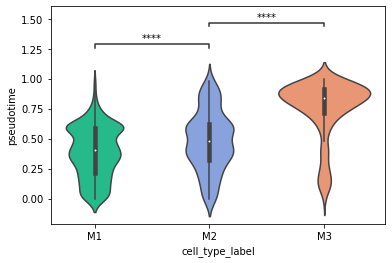

In [15]:
# Plot 
current_pairs = [("M1", "M2"), ("M2", "M3")]
# current_pairs = [("A1", "A2"), ("A2", "A3")]
# current_pairs = [("OL1", "OL2"), ("OL2", "OL3")]

fig, ax = plt.subplots()
sns.violinplot(x='cell_type_label', y='pseudotime', data=time_df, palette=sub_cpl, ax=ax)
add_stat_annotation(ax, x='cell_type_label', y='pseudotime', data=time_df,
                    box_pairs=current_pairs,
                    test='Mann-Whitney', text_format='star', verbose=2, line_offset_to_box=.2)
plt.savefig(f'figures/{sub_id}_pseudotime_distribution.pdf')
plt.show()

### Subtype per sample pseudotime distribution

In [19]:
# load pseudotime file 
sub_id = "Micro" # OPC_Oligo
time_df = pd.read_csv(f'./pseudotime/AD_{sub_id}_pseudotime.csv')
time_df 

orig_index        sample  area  tau     x     y    batch       time  \
0             13  AD_mouse9494  5765  0.0  3826     8  batch_2  13_months   
1             42  AD_mouse9494  9402  0.0  2317    31  batch_2  13_months   
2             45  AD_mouse9494  7073  0.0  1292    34  batch_2  13_months   
3             51  AD_mouse9494  7603  0.0  2178    37  batch_2  13_months   
4             53  AD_mouse9494  9387  0.0   885    35  batch_2  13_months   
...          ...           ...   ...  ...   ...   ...      ...        ...   
1718        7991  AD_mouse9498  8271  0.0  5627  6530  batch_2  13_months   
1719        8020  AD_mouse9498  6752  0.0  1209  6549  batch_2  13_months   
1720        8117  AD_mouse9498  6811  0.0  4117  6625  batch_2  13_months   
1721        8136  AD_mouse9498  9350  0.0  3953  6639  batch_2  13_months   
1722        8165  AD_mouse9498  6374  0.0  4287  6655  batch_2  13_months   

        group  n_genes_by_counts  ...  X__is_in_cluster__  top_level  \
0     disease                 90  ...               False      Micro   
1     disease                135  ...               False      Micro   
2     disease                102  ...               False      Micro   
3     disease                 89  ...               False      Micro   
4     disease                172  ...               False      Micro   
...       ...                ...  ...                 ...        ...   
1718  control                120  ...               False      Micro   
1719  control                 95  ...               False      Micro   
1720  control                101  ...               False      Micro   
1721  control                100  ...               False      Micro   
1722  control                 53  ...               False      Micro   

            cell_type       region  cell_type_label  nCount_RNA  nFeature_RNA  \
0     Micro_Cst7/Ctsb  Hippocampus               M3         109            87   
1         Micro_Gpr34  Hippocampus               M2         169           128   
2         Micro_Gpr34  Hippocampus               M2         106            95   
3     Micro_Cst7/Ctsb  Hippocampus               M3         111            83   
4         Micro_Gpr34  Hippocampus               M2         188           159   
...               ...          ...              ...         ...           ...   
1718            Micro  Hippocampus               M1         132           113   
1719      Micro_Gpr34  Hippocampus               M2         104            93   
1720            Micro  Hippocampus               M1         111            93   
1721            Micro  Hippocampus               M1         111            91   
1722      Micro_Gpr34  Hippocampus               M2          68            51   

     pseudotime     UMAP1     UMAP2  
0     11.938498 -1.016800  0.815882  
1     16.923545 -4.412405 -1.738135  
2     18.651894 -2.404822 -2.965408  
3     16.975059 -3.537116 -2.384354  
4      0.501767  4.437535  0.198064  
...         ...       ...       ...  
1718  13.079931 -2.110824  1.271107  
1719  11.380684 -1.551972  2.806060  
1720  11.887461 -0.855873  0.926867  
1721   4.192917  0.755105 -2.210421  
1722   7.784228  0.362926 -0.257075  

[1723 rows x 26 columns]

In [20]:
# Set category order 
time_df['sample'] = time_df['sample'].astype('category')
time_df['sample'] = time_df['sample'].cat.reorder_categories(['AD_mouse9735', 'AD_mouse9723', 'AD_mouse9498', 'AD_mouse9494'])

time_df['cell_type_label'] = time_df['cell_type_label'].astype('category')

# Normalize pseudotime 
time_df['pseudotime'] = time_df['pseudotime'] / time_df['pseudotime'].max()

M3
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

AD_mouse9735 v.s. AD_mouse9723: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.551e-01 U_stat=5.400e+01
AD_mouse9498 v.s. AD_mouse9494: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.579e-01 U_stat=7.600e+01
AD_mouse9723 v.s. AD_mouse9494: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.929e-09 U_stat=1.870e+04


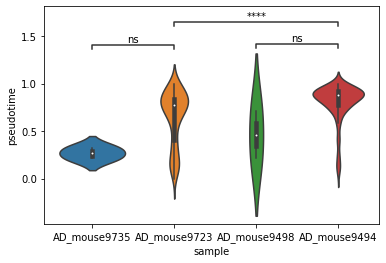

M2
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

AD_mouse9735 v.s. AD_mouse9723: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.936e-02 U_stat=3.268e+03
AD_mouse9498 v.s. AD_mouse9494: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.656e-09 U_stat=3.136e+03
AD_mouse9723 v.s. AD_mouse9494: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.594e-04 U_stat=4.437e+03


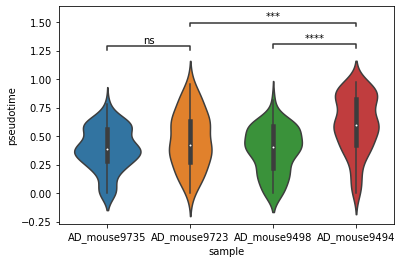

M1
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

AD_mouse9735 v.s. AD_mouse9723: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.814e-01 U_stat=1.692e+04
AD_mouse9498 v.s. AD_mouse9494: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.575e-02 U_stat=1.728e+04
AD_mouse9723 v.s. AD_mouse9494: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.558e+04


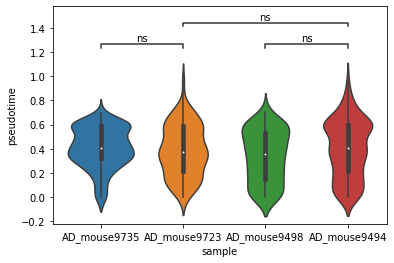

In [23]:
for current_type in time_df['cell_type_label'].unique():
    print(current_type)
    current_df = time_df.loc[time_df['cell_type_label'] == current_type, ]
    fig, ax = plt.subplots()
    sns.violinplot(x='sample', y='pseudotime', data=current_df, ax=ax)
    add_stat_annotation(ax, x='sample', y='pseudotime', data=current_df,
                        box_pairs=[("AD_mouse9735", "AD_mouse9723"), ("AD_mouse9498", "AD_mouse9494"), ("AD_mouse9723", "AD_mouse9494")],
                        test='Mann-Whitney', text_format='star', verbose=2, line_offset_to_box=.2)
    # plt.savefig(f'figures/{sub_id}_pseudotime_distribution_sample.pdf')
    plt.show()

AD_mouse9494
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

M1 v.s. M2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.023e-13 U_stat=1.283e+04
M2 v.s. M3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.278e-19 U_stat=1.455e+04


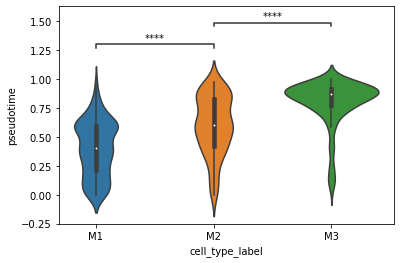

AD_mouse9723
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

M1 v.s. M2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.378e-02 U_stat=5.865e+03
M2 v.s. M3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.607e-06 U_stat=3.812e+03


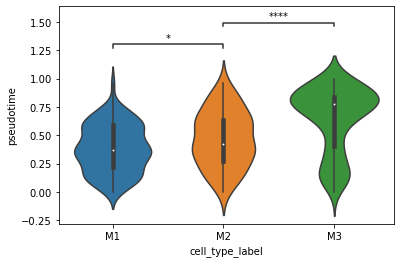

AD_mouse9735
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

M1 v.s. M2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.919e-01 U_stat=8.783e+03
M2 v.s. M3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.680e-01 U_stat=1.540e+02


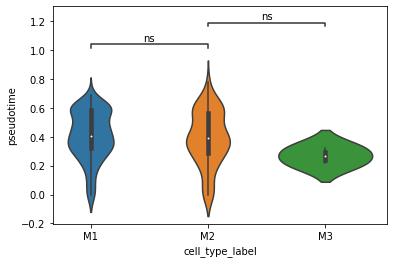

AD_mouse9498
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

M1 v.s. M2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.211e-01 U_stat=5.052e+03
M2 v.s. M3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.976e-01 U_stat=5.700e+01


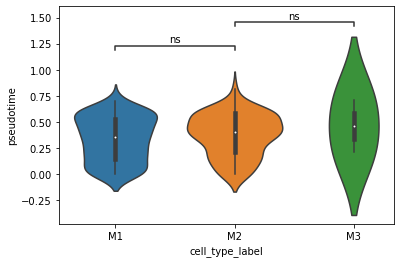

In [25]:
current_pairs = [("M1", "M2"), ("M2", "M3")]

for sample in time_df['sample'].unique():
    print(sample)
    current_df = time_df.loc[time_df['sample'] == sample, ]
    fig, ax = plt.subplots()
    sns.violinplot(x='cell_type_label', y='pseudotime', data=current_df, ax=ax)
    add_stat_annotation(ax, x='cell_type_label', y='pseudotime', data=current_df,
                        box_pairs=current_pairs,
                        test='Mann-Whitney', text_format='star', verbose=2, line_offset_to_box=.2)
    # plt.savefig(f'figures/{sub_id}_pseudotime_distribution_sample.pdf')
    plt.show()

### Spatial cell type map of multiple groups

In [ ]:
# group spatial cell type map 

plot_type = 'top_level'
# plot_list = ['Ex', 'Inhi']
# plot_list = ['Endo', 'SMC']
# plot_list = ['CA1', 'CA2', 'CA3', 'DG', 'LHb']
# plot_list = ['Oligo', 'OPC']
# plot_list = ['Micro_Cst7/Ctsb', 'Oligo_Neat1/Enpp2']
# plot_list = ['Micro_Cst7/Ctsb', 'Astro']
# plot_list = ['Astro_Gfap/Vim', 'Oligo_Klk6']

curr_cells = adata.obs[plot_type].isin(plot_list)
sdata = adata[curr_cells, :]
# sdata
sdata.obs[plot_type] = sdata.obs[plot_type].cat.reorder_categories(plot_list)

if plot_list[0] in ['Micro_Cst7/Ctsb', 'Astro_Gfap/Vim']:
    curr_cpl = ['#fc8d62', '#1ec700']
    curr_cpl = sns.color_palette(curr_cpl)
else:
    curr_cpl = sns.color_palette('Set1', len(plot_list)+1)
    curr_cpl.pop(0)
    
curr_cmap = ListedColormap(curr_cpl.as_hex())
sns.palplot(curr_cpl, size=3)
plt.xticks(range(len(plot_list)), plot_list, size=10, rotation=45)
plt.tight_layout()
plt.savefig(f'./figures/color_legend.png')
plt.show()

# Spatial cell type 
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    current_key = f"{sample}_morph"
    current_index = sdata.obs['sample'] == sample
    # change to new color 
    sdata.uns[current_key]['colors'] = sdata.obs.loc[current_index, plot_type].cat.codes.values
    sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
    
    su.plot_poly_cells_cluster_by_sample(sdata, sample, curr_cmap, show_plaque=True, show_tau=True,
                                        figscale=30, width=10, height=10, save=True, show=False)

### Gene set score related

In [ ]:
# Astro related gene module 
pan_reactive_genes = ['LCN2', 'STEAP4', 'S1PR3', 'TIMP2', 'HSPB1',
                     'CXCL10', 'CD44', 'OSMR', 'CP', 'SERPINA3N',
                     'ASPG', 'VIM', 'GFAP']
a1_genes = ['H2-T23', 'SERPING1', 'H2-D1', 'GGTA1', 'LIGP1', 'GBP2',
           'FBIN5', 'UGT1A1', 'FKBP5', 'PSMB8', 'SRGN', 'AMIGO2']
a2_genes = ['CLCF1', 'TGM1', 'PTX3', 'S100A10', 'SPHK1', 'CD109', 'PTGS2',
           'EMP1', 'SLC10A6', 'TM4SF1', 'B3GNT5', 'CD14']

# module from file
module_name = 'Neurodegen'

gene_module = pd.read_excel('Friedman_modules_for_Julia.xlsx', sheet_name=module_name)
gene_module = gene_module.iloc[:, 0].astype(str).str.upper().to_list()

In [ ]:
# group color map
group_cpl = sns.color_palette('tab10', 2)
sns.palplot(group_cpl, size=3)

In [ ]:
# print module genes
gene_module = list(set(gene_module) & set(adata.var.index))
print(len(gene_module))
print(gene_module)

In [ ]:
module_name = 'Pan reactive'

region_type = 'Cortex'
current_index = (adata.obs['region'] == region_type) & (~adata.obs['top_level'].isin(['CA1', 'CA2', 'CA3', 'DG']))
rdata = adata[current_index, :]
sc.tl.score_genes(rdata, gene_module)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x='top_level', y='score', hue='group', data=rdata.obs, ax=ax, palette=group_cpl)
add_stat_annotation(ax, data=rdata.obs, x='top_level', y='score', hue='group',
                    box_pairs=[(("Ex", "disease"), ("Ex", "control")),
                              (("Inhi", "disease"), ("Inhi", "control")),
                               (("Astro", "disease"), ("Astro", "control")),
                               (("Oligo", "disease"), ("Oligo", "control")),
                               (("OPC", "disease"), ("OPC", "control")),
                               (("Endo", "disease"), ("Endo", "control")),
                               (("SMC", "disease"), ("SMC", "control")),
                              (("Micro", "disease"), ("Micro", "control"))],
                    test='Mann-Whitney', text_format='star', verbose=2)

plt.title(f'A2 gene set score in {region_type}')
plt.show()

In [ ]:
subset_type = 'Astro'
current_index = rdata.obs['top_level'] == subset_type
sdata = rdata[current_index, :]
sc.tl.score_genes(sdata, gene_module)

# Check color legend
curr_cell_type = [] 
for cell_type in sdata.uns['cell_type_order']:
    if cell_type in sdata.obs['cell_type'].unique():
        curr_cell_type.append(cell_type)

sub_cpl = []
for i in curr_cell_type:
    if '/' in i:
        curr_key = i.split('/')
        sub_cpl.append(sdata.uns['sub_rgb_dict'][curr_key[0]][curr_key[1]])
    else:       
        sub_cpl.append(sdata.uns['sub_rgb_dict'][i])

sub_cpl = sns.color_palette(sub_cpl)
sub_cmap = ListedColormap(sub_cpl.as_hex())
sns.palplot(sub_cpl, size=3)
plt.xticks(range(len(curr_cell_type)), curr_cell_type, size=10, rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x='cell_type', y='score', data=sdata.obs, ax=ax, palette=sub_cpl)
plt.title(f'A1 gene set score in Astrocytes')
add_stat_annotation(ax, data=sdata.obs, x='cell_type', y='score',
                    box_pairs=[("Astro", "Astro_Gfap/Vim")],
                    test='Mann-Whitney', text_format='star', verbose=2)
plt.show()

### Region-wise cell type density stacked bar plot

In [6]:
# Load region mask 
# Load data and store the information to uns (use scaled version to save computational time)
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    # Load region segmentation
    current_seg_path = os.path.join(sample, 'scaled/bill-labels.tif')
    current_img = tifffile.imread(current_seg_path)
    
    # Store the images to adata object
    current_key = f"{sample}_morph"
    adata.uns[current_key]['region'] = current_img

AD_mouse9494
AD_mouse9498
AD_mouse9723
AD_mouse9735


In [7]:
adata.uns['top_hex_dict']['OPC']

'#8600d4'

Trying to set attribute `.obs` of view, copying.


Hippocampus


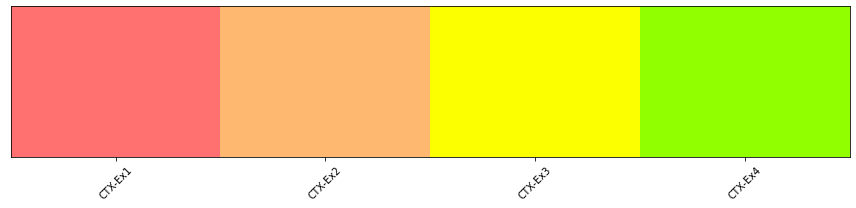

AD_mouse9735
Hippocampus, AD_mouse9735, 19396453
AD_mouse9723
Hippocampus, AD_mouse9723, 16509178
AD_mouse9498
Hippocampus, AD_mouse9498, 17766636
AD_mouse9494
Hippocampus, AD_mouse9494, 25977773


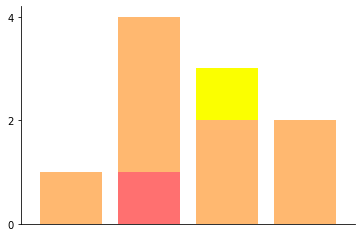

In [14]:
# Subset of regions

all_list = []

# region_list = ['Cortex', 'Corpus Callosum', 'Hippocampus']
# region_list = ['Cortex']
# region_list = ['Corpus Callosum']
region_list = ['Hippocampus']
# region_list = ['Cortex', 'Subcortical']
# region_list = ['Subcortical']

sub_id = ['CTX-Ex']
# sub_id = ['Inh']
# sub_id = ['Oligo', 'OPC']
# sub_id = ['CA1', 'CA2', 'CA3', 'DG']

show_colormap = True

# Iterate region 
for r, current_region in enumerate(region_list):
    print(current_region)
    if current_region == 'Cortex':
        current_index = (adata.obs['region'] == current_region) & (~adata.obs['top_level'].isin(['CA1', 'CA2', 'CA3', 'DG', 'LHb']))
    elif current_region == 'Corpus Callosum':
        current_index = (adata.obs['region'] == current_region) & (~adata.obs['top_level'].isin(['Ex', 'Inhi', 'CA1', 'CA2', 'CA3', 'DG', 'LHb']))
    elif current_region == 'Hippocampus':
        current_index = (adata.obs['region'] == current_region) 
    elif current_region == 'Subcortical':
        current_index = (adata.obs['region'].isin(['Corpus Callosum', 'Hippocampus'])) & (~adata.obs['top_level'].isin(['Ex']))
    
    # cell type Subset
    rdata = adata[current_index, :]
    curr_cells = rdata.obs['top_level'].isin(sub_id)
    sdata = rdata[curr_cells, :]
    sdata.obs['sample'] = sdata.obs['sample'].cat.reorder_categories(['AD_mouse9735', 'AD_mouse9723', 'AD_mouse9498', 'AD_mouse9494'])

    # Check color legend
    curr_cell_type = [] 
    for cell_type in sdata.uns['cell_type_label_order']:
        if cell_type in sdata.obs['cell_type_label'].unique():
            curr_cell_type.append(cell_type)

    sub_cpl = []
    for i in curr_cell_type:
        if '/' in i:
            curr_key = i.split('/')
            sub_cpl.append(sdata.uns['label_rgb_dict'][curr_key[0]][curr_key[1]])
        else:       
            sub_cpl.append(sdata.uns['label_rgb_dict'][i])

    # sub_cpl = ['#ff7070', '#ffb870', '#fbff00', '#91ff00'] # Ex
    # sub_cpl = ['#006cf0', '#0da802', '#c29b00', '#ff94c9'] # Inhi
    # sub_cpl = ['#70fffd', '#0084ff', '#9500ff', '#910000'] # Hippo Ex
    # sub_cpl = ['#2fe04d', '#2c73e6', '#fa733e', '#8600d4', '#8600d4']
    
    sub_cpl = sns.color_palette(sub_cpl)
    sub_cmap = ListedColormap(sub_cpl.as_hex())
    if show_colormap:
        sns.palplot(sub_cpl, size=3)
        plt.xticks(range(len(curr_cell_type)), curr_cell_type, size=10, rotation=45)
        plt.tight_layout()
        # plt.savefig(f'./figures/color_legend_{sub_id}.png')
        plt.show()
        
    # normalized barplot
    region_dict = {'Cortex':1, 'Corpus Callosum':2, 'Hippocampus':3}
    sample_tags = ['Control (8 months)', 'Disease (8 months)', 'Control (13 months)', 'Disease (13 months)']

    cell_dist_list = []
    for i, sample in enumerate(sdata.obs['sample'].cat.categories):
        print(sample)
        curr_cells = (sdata.obs['sample'] == sample)
        temp = sdata[curr_cells, :]

        cell_dist = pd.DataFrame(temp.obs['cell_type_label'].value_counts())
        cell_dist['counts'] = cell_dist['cell_type_label']
        cell_dist['cell_type_label'] = cell_dist.index
        cell_dist['cell_type_label'] = cell_dist['cell_type_label'].astype(object)
        cell_dist = cell_dist.reset_index(drop=True)
        # cell_dist = cell_dist.loc[cell_dist['counts'] != 0, :]
        # cell_dist['cell_type'] = cell_dist['cell_type'].astype('category')

        for j in curr_cell_type:
            if j not in cell_dist['cell_type_label'].unique():
                cell_dist = cell_dist.append({'cell_type_label': j, 'counts': 0}, ignore_index=True)

        cell_dist['cell_type_label'] = cell_dist['cell_type_label'].astype('category')
        cell_dist['cell_type_label'] = cell_dist['cell_type_label'].cat.reorder_categories(curr_cell_type)
        cell_dist['sample'] = sample_tags[i]
        
        region_areas = {}
        for k, region in enumerate(regionprops(sdata.uns[f'{sample}_morph']['region'])):
            # print(region.area)
            region_areas[region.label] = region.area
            
        current_area = 0
        if current_region == 'Subcortical':
            current_area = (region_areas[2] + region_areas[3]) * 0.315 * 0.315
        else:
            current_area = region_areas[region_dict[current_region]] # * 0.315 * 0.315
                    
        print(f"{current_region}, {sample}, {current_area}")
        # print(cell_dist)
        cell_dist['counts'] = cell_dist['counts'] / current_area * 1000000
        cell_dist['counts'] = cell_dist['counts'].round()
        cell_dist['counts'] = cell_dist['counts'].astype(int)
        cell_dist['region'] = current_region
        cell_dist = cell_dist.reset_index(drop=True)
    
        # print(cell_dist.shape)
        cell_dist_list.append(cell_dist)
        
    cell_dist_total = pd.concat(cell_dist_list)
    cell_dist_total['sample'] = cell_dist_total['sample'].astype('category')
    cell_dist_total['sample'] = cell_dist_total['sample'].cat.reorder_categories(sample_tags)
    df = cell_dist_total.pivot(columns='cell_type_label',index='sample').fillna(0)
    # print(df)
    # plot it
    fig, ax = plt.subplots()
    df.plot(kind='bar', stacked=True, legend=False, cmap=sub_cmap, ax=ax, width=0.8)
    #plt.setp(ax.patches, linewidth=1, edgecolor='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    plt.locator_params(axis='y', nbins=4)
    # plt.savefig(f'./figures/{sub_id[0]}_{current_region}_composition.pdf')
    plt.show()
    
    df['total'] = df['counts'].sum(axis=1)
    df_out = df.loc[:, ['counts', 'total']]
    # df_out.to_csv(f'./figures/{sub_id[0]}_{current_region}_composition.csv')

In [12]:
df_out

counts                         total
cell_type_label     CTX-Ex1 CTX-Ex2 CTX-Ex3 CTX-Ex4      
sample                                                   
Control (8 months)      373     294     150     439  1256
Disease (8 months)      317     518     161     278  1274
Control (13 months)     367     388     165     261  1181
Disease (13 months)     283     313     217     447  1260

In [76]:
df_out.index.names = ['']
df_out.columns.names = ['', '']
df_out.columns[-1]

('total', '')

Trying to set attribute `.obs` of view, copying.


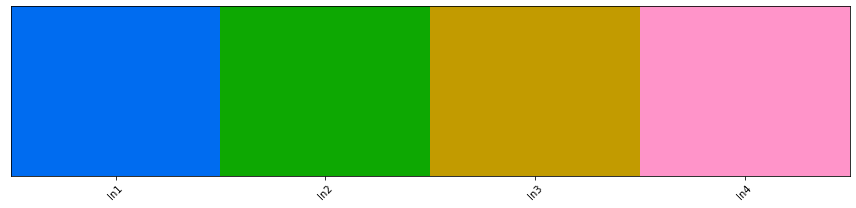

AD_mouse9735
AD_mouse9735, 3933413.946
AD_mouse9723
AD_mouse9723, 3892776.1488
AD_mouse9498
AD_mouse9498, 3784044.79845
AD_mouse9494
AD_mouse9494, 4431595.781025


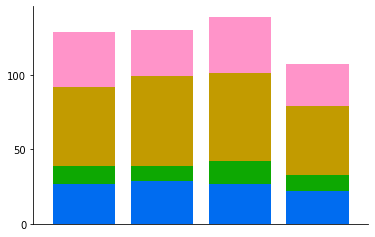

In [29]:
# Overall 

sub_id = 'Inhi'
show_colormap = True

curr_cells = adata.obs['top_level'] == sub_id
sdata = adata[curr_cells, :]
sdata.obs['sample'] = sdata.obs['sample'].cat.reorder_categories(['AD_mouse9735', 'AD_mouse9723', 'AD_mouse9498', 'AD_mouse9494'])

# Check color legend
curr_cell_type = [] 
for cell_type in sdata.uns['cell_type_label']:
    if cell_type in sdata.obs['cell_type_label'].unique():
        curr_cell_type.append(cell_type)

sub_cpl = []
for i in curr_cell_type:
    if '/' in i:
        curr_key = i.split('/')
        sub_cpl.append(sdata.uns['label_rgb_dict'][curr_key[0]][curr_key[1]])
    else:       
        sub_cpl.append(sdata.uns['label_rgb_dict'][i])

# sub_cpl = ['#ff7070', '#ffb870', '#fbff00', '#91ff00'] # Ex
sub_cpl = ['#006cf0', '#0da802', '#c29b00', '#ff94c9'] 
sub_cpl = sns.color_palette(sub_cpl)
sub_cmap = ListedColormap(sub_cpl.as_hex())
if show_colormap:
    sns.palplot(sub_cpl, size=3)
    plt.xticks(range(len(curr_cell_type)), curr_cell_type, size=10, rotation=45)
    plt.tight_layout()
    # plt.savefig(f'./figures/color_legend_{sub_id}.png')
    plt.show()

cell_dist_list = []
for i, sample in enumerate(sdata.obs['sample'].cat.categories):
    print(sample)
    curr_cells = (sdata.obs['sample'] == sample)
    temp = sdata[curr_cells, :]

    cell_dist = pd.DataFrame(temp.obs['cell_type_label'].value_counts())
    cell_dist['counts'] = cell_dist['cell_type_label']
    cell_dist['cell_type_label'] = cell_dist.index
    cell_dist['cell_type_label'] = cell_dist['cell_type_label'].astype(object)
    cell_dist = cell_dist.reset_index(drop=True)
    # cell_dist = cell_dist.loc[cell_dist['counts'] != 0, :]
    # cell_dist['cell_type'] = cell_dist['cell_type'].astype('category')

    for j in curr_cell_type:
        if j not in cell_dist['cell_type_label'].unique():
            cell_dist = cell_dist.append({'cell_type_label': j, 'counts': 0}, ignore_index=True)

    cell_dist['cell_type_label'] = cell_dist['cell_type_label'].astype('category')
    cell_dist['cell_type_label'] = cell_dist['cell_type_label'].cat.reorder_categories(curr_cell_type)
    cell_dist['sample'] = sample_tags[i]
    

    current_area = sdata.uns[f'{sample}_morph']['region'].shape[0] * sdata.uns[f'{sample}_morph']['region'].shape[1] * 0.315 * 0.315

    print(f"{sample}, {current_area}")

    cell_dist['counts'] = cell_dist['counts'] / current_area * 1000000
    cell_dist['counts'] = cell_dist['counts'].round()
    cell_dist['counts'] = cell_dist['counts'].astype(int)
    cell_dist['region'] = current_region
    cell_dist = cell_dist.reset_index(drop=True)
    
    # print(cell_dist.shape)
    cell_dist_list.append(cell_dist)

cell_dist_total = pd.concat(cell_dist_list)
cell_dist_total['cell_type_label'] = cell_dist_total['cell_type_label'].astype('category')
cell_dist_total['sample'] = cell_dist_total['sample'].astype('category')
cell_dist_total['sample'] = cell_dist_total['sample'].cat.reorder_categories(['Control (8 months)', 'Disease (8 months)', 'Control (13 months)', 'Disease (13 months)'])

df = cell_dist_total.pivot(columns='cell_type_label',index='sample').fillna(0)
# plot it
fig, ax = plt.subplots()
df.plot(kind='bar', stacked=True, legend=False, cmap=sub_cmap, ax=ax, width=0.8)
#plt.setp(ax.patches, linewidth=1, edgecolor='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().set_visible(False)
plt.locator_params(axis='y', nbins=4)
plt.savefig(f'./figures/{sub_id}_overall_composition.pdf')
plt.show()

### Tau positive cell type composition

In [4]:
adata = sc.read_h5ad('./output/2021-04-22-starmap-mAD-scaled.h5ad')
vdata = sc.read_h5ad('../2021-03-20-mAD-64-genes-reads-assignment/output/2021-04-22-starmap-mAD-64-genes-scaled.h5ad')

In [ ]:
# Load adata morphology
# Load data and store the information to uns (use scaled version to save computational time)
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    # Load segmentation
    current_seg_path = os.path.join(sample, 'scaled/labeled_cells.tif')
    current_img = tifffile.imread(current_seg_path)
    
    # Load plaque image
    current_plaque_path = os.path.join(sample, 'scaled/plaque.tif')
    current_plaque = tifffile.imread(current_plaque_path)
    # uniform manual threshold 
    current_plaque = gaussian(current_plaque.astype(np.float), 2) > 30
    # current_plaque = remove_small_objects(current_plaque, min_size=64, connectivity=4)
    
    # Load tau image
    current_tau_path = os.path.join(sample, 'scaled/tau_mask.tif')
    current_tau = tifffile.imread(current_tau_path)

    # Store the images to adata object
    current_key = f"{sample}_morph"
    adata.uns[current_key] = {}
    adata.uns[current_key]['label_img'] = current_img
    adata.uns[current_key]['plaque'] = current_plaque
    adata.uns[current_key]['tau'] = current_tau

# Restore convex hull and top-level info
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    adata.uns[current_key]['qhulls'], adata.uns[current_key]['coords'], adata.uns[current_key]['centroids'] = su.get_qhulls(adata.uns[current_key]['label_img'])
    
    current_index = adata.obs['sample'] == sample
    adata.uns[current_key]['good_cells'] = adata.obs.loc[current_index, 'orig_index'].astype(int).values
    adata.uns[current_key]['colors'] = adata.obs.loc[current_index, 'top_level'].cat.codes.values
    
    # add tau positive info
    # adata.uns[current_key]['tau_index'] = (adata.obs['tau'] > tau_threshold) & (current_index)
    

In [21]:
# Load vdata morphology
# Load data and store the information to uns (use scaled version to save computational time)
for sample in sorted(vdata.obs['sample'].unique()):
    print(sample)
    
    # Load segmentation
    current_seg_path = os.path.join('../2021-03-20-mAD-64-genes-reads-assignment', sample, 'scaled/labeled_cells.tif')
    current_img = tifffile.imread(current_seg_path)
    
    # Load plaque image
    current_plaque_path = os.path.join('../2021-03-20-mAD-64-genes-reads-assignment', sample, 'scaled/plaque.tif')
    current_plaque = tifffile.imread(current_plaque_path)
    # uniform manual threshold 
    current_plaque = gaussian(current_plaque.astype(np.float), 2) > 30
    # current_plaque = remove_small_objects(current_plaque, min_size=64, connectivity=4)
    
    # Load tau image
    current_tau_path = os.path.join('../2021-03-20-mAD-64-genes-reads-assignment', sample, 'scaled/tau_mask.tif')
    current_tau = tifffile.imread(current_tau_path)

    # Store the images to adata object
    current_key = f"{sample}_morph"
    vdata.uns[current_key] = {}
    vdata.uns[current_key]['label_img'] = current_img
    vdata.uns[current_key]['plaque'] = current_plaque
    vdata.uns[current_key]['tau'] = current_tau

# Restore convex hull and top-level info
for sample in sorted(vdata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    vdata.uns[current_key]['qhulls'], vdata.uns[current_key]['coords'], vdata.uns[current_key]['centroids'] = su.get_qhulls(vdata.uns[current_key]['label_img'])
    
    current_index = vdata.obs['sample'] == sample
    vdata.uns[current_key]['good_cells'] = vdata.obs.loc[current_index, 'orig_index'].astype(int).values
    vdata.uns[current_key]['colors'] = vdata.obs.loc[current_index, 'top_level'].cat.codes.values
    
    # add tau positive info
    # tau_threshold = 30
    # adata.uns[current_key]['tau_index'] = (adata.obs['tau'] > tau_threshold) & (current_index)
    

AD_mouse9721
AD_mouse9781
AD_mouse9919
AD_mouse9930
AD_mouse9721
Geting ConvexHull...
Used 9391 / 9391
AD_mouse9781
Geting ConvexHull...
Used 11328 / 11328
AD_mouse9919
Geting ConvexHull...
Used 10404 / 10404
AD_mouse9930
Geting ConvexHull...
Used 9829 / 9829


In [ ]:
adata.uns['label_hex_dict']['CTX-Ex1'] = '#ff7070'
adata.uns['label_hex_dict']['CTX-Ex2'] = '#ffb870'
adata.uns['label_hex_dict']['CTX-Ex3'] = '#fbff00'
adata.uns['label_hex_dict']['CTX-Ex4'] = '#91ff00'
adata.uns['label_hex_dict']['CA1'] = '#70fffd'
adata.uns['label_hex_dict']['CA2'] = '#0084ff'
adata.uns['label_hex_dict']['CA3'] = '#9500ff'
adata.uns['label_hex_dict']['DG'] = '#910000'

adata.uns['label_hex_dict']['In1'] = '#006cf0'
adata.uns['label_hex_dict']['In2'] = '#0da802'
adata.uns['label_hex_dict']['In3'] = '#c29b00'
adata.uns['label_hex_dict']['In4'] = '#ff94c9'

8_months
13_months


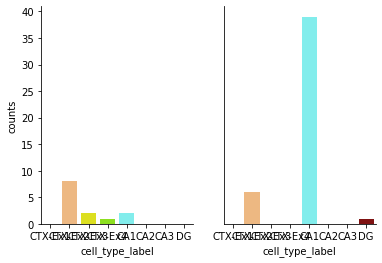

In [139]:
plot_group = 'Ex'
tau_threshold = 7

tau_df_list = []
for time in ['8_months', '13_months']:
    print(time)
    current_tau_df = adata.obs.loc[(adata.obs['tau'] > tau_threshold) & (adata.obs['time'] == time), ]
    if plot_group == 'Ex':
        current_tau_df = current_tau_df.loc[current_tau_df['top_level'].isin(['Ex', 'CA1', 'CA2', 'CA3', 'DG']), ]
    elif plot_group == 'Inhi':
        current_tau_df = current_tau_df.loc[current_tau_df['top_level'].isin(['Inhi']), ]
        
    current_tau_df = pd.DataFrame(current_tau_df['cell_type_label'].value_counts())
    current_tau_df['time'] = time
    # current_tau_df = current_tau_df.loc[current_tau_df['cell_type_label'] != 0, ]
    tau_df_list.append(current_tau_df)
    
tau_df_total = pd.concat(tau_df_list)
tau_df_total['counts'] = tau_df_total['cell_type_label']

if plot_group == 'Ex':
    tau_df_total = tau_df_total.loc[['CTX-Ex1', 'CTX-Ex2', 'CTX-Ex3', 'CTX-Ex4', 'CA1', 'CA2', 'CA3', 'DG'], ]
elif plot_group == 'Inhi':
    tau_df_total = tau_df_total.loc[['In1', 'In2', 'In3', 'In4'], ]
    
tau_df_total['cell_type_label'] = tau_df_total.index
tau_df_total['cell_type_label'] = tau_df_total['cell_type_label'].astype(object)
tau_df_total = tau_df_total.reset_index(drop=True)
tau_df_total['time'] = tau_df_total['time'].astype('category')
tau_df_total['time'] = tau_df_total['time'].cat.reorder_categories(['8_months', '13_months'])

ax1 = plt.subplot(121)
ax1_df = tau_df_total.loc[tau_df_total['time'] == '8_months', ]
ax1_cpl = sns.color_palette([adata.uns['label_hex_dict'][c] for c in ax1_df['cell_type_label']])
sns.barplot(x='cell_type_label', y='counts', data=ax1_df, palette=ax1_cpl,
            ax=ax1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# share x only
ax2 = plt.subplot(122, sharey=ax1)
ax2_df = tau_df_total.loc[tau_df_total['time'] == '13_months', ]
ax2_cpl = sns.color_palette([adata.uns['label_hex_dict'][c] for c in ax2_df['cell_type_label']])
sns.barplot(x='cell_type_label', y='counts', data=ax2_df, palette=ax2_cpl,
            ax=ax2)
# make these tick labels invisible
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.get_yaxis().set_visible(False)
plt.savefig(f'./figures/{plot_group}_tau_positive_composition_2766.pdf')
plt.show()


8_months
13_months


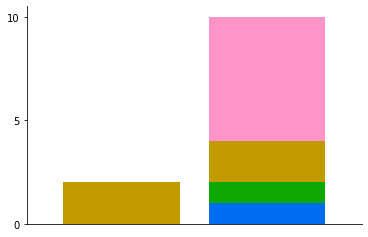

In [168]:
plot_group = 'Inhi'
tau_threshold = 7

tau_df_list = []
for time in ['8_months', '13_months']:
    print(time)
    current_tau_df = adata.obs.loc[(adata.obs['tau'] > tau_threshold) & (adata.obs['time'] == time), ]
    if plot_group == 'Ex':
        current_tau_df = current_tau_df.loc[current_tau_df['top_level'].isin(['Ex', 'CA1', 'CA2', 'CA3', 'DG']), ]
    elif plot_group == 'Inhi':
        current_tau_df = current_tau_df.loc[current_tau_df['top_level'].isin(['Inhi']), ]
        
    current_tau_df = pd.DataFrame(current_tau_df['cell_type_label'].value_counts())
    current_tau_df['time'] = time
    # current_tau_df = current_tau_df.loc[current_tau_df['cell_type_label'] != 0, ]
    tau_df_list.append(current_tau_df)
    
tau_df_total = pd.concat(tau_df_list)
tau_df_total['counts'] = tau_df_total['cell_type_label']

if plot_group == 'Ex':
    current_order = ['CTX-Ex1', 'CTX-Ex2', 'CTX-Ex3', 'CTX-Ex4', 'CA1', 'CA2', 'CA3', 'DG']
    tau_df_total = tau_df_total.loc[current_order, ]
elif plot_group == 'Inhi':
    current_order = ['In1', 'In2', 'In3', 'In4']
    tau_df_total = tau_df_total.loc[current_order, ]
    
tau_df_total['cell_type_label'] = tau_df_total.index
tau_df_total['cell_type_label'] = tau_df_total['cell_type_label'].astype(object)
tau_df_total['cell_type_label'] = tau_df_total['cell_type_label'].astype('category')
tau_df_total['cell_type_label'] = tau_df_total['cell_type_label'].cat.reorder_categories(current_order)
tau_df_total = tau_df_total.reset_index(drop=True)
tau_df_total['time'] = tau_df_total['time'].astype('category')
tau_df_total['time'] = tau_df_total['time'].cat.reorder_categories(['8_months', '13_months'])

df = tau_df_total.pivot(columns='cell_type_label',index='time').fillna(0)
sub_cmap = ListedColormap([adata.uns['label_hex_dict'][c] for c in tau_df_total['cell_type_label']])
# plot it
fig, ax = plt.subplots()
df.plot(kind='bar', stacked=True, legend=False, cmap=sub_cmap, ax=ax, width=0.8)
#plt.setp(ax.patches, linewidth=1, edgecolor='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().set_visible(False)
plt.locator_params(axis='y', nbins=4)
plt.savefig(f'./figures/{plot_group}_tau_positive_composition.pdf')
plt.show()

8_months
13_months
8_months
13_months


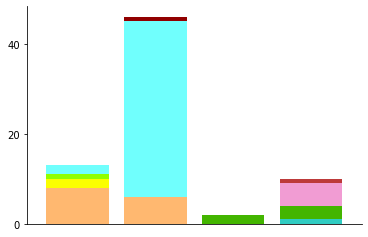

In [89]:
tau_threshold = 7

tau_df_total_list = []
for plot_group in ['CTX-Ex', 'Inh']:
    
    tau_df_list = []
    
    for time in ['8_months', '13_months']:
        print(time)
        current_tau_df = adata.obs.loc[(adata.obs['tau'] > tau_threshold) & (adata.obs['time'] == time), ]
        if plot_group == 'CTX-Ex':
            current_tau_df = current_tau_df.loc[current_tau_df['top_level'].isin(['CTX-Ex', 'CA1', 'CA2', 'CA3', 'DG']), ]
        elif plot_group == 'Inh':
            current_tau_df = current_tau_df.loc[current_tau_df['top_level'].isin(['Inh']), ]

        current_tau_df = pd.DataFrame(current_tau_df['cell_type_label'].value_counts())
        current_tau_df['time'] = time
        # current_tau_df = current_tau_df.loc[current_tau_df['cell_type_label'] != 0, ]
        tau_df_list.append(current_tau_df)

    tau_df_total = pd.concat(tau_df_list)
    tau_df_total['counts'] = tau_df_total['cell_type_label']

    if plot_group == 'CTX-Ex':
        current_order = ['CTX-Ex1', 'CTX-Ex2', 'CTX-Ex3', 'CTX-Ex4', 'CA1', 'CA2', 'CA3', 'DG']
        tau_df_total = tau_df_total.loc[current_order, ]
    elif plot_group == 'Inh':
        current_order = ['Inh1', 'Inh2', 'Inh3', 'Inh4', 'Inh5', 'Inh6']
        tau_df_total = tau_df_total.loc[current_order, ]

    tau_df_total['cell_type_label'] = tau_df_total.index
    tau_df_total['cell_type_label'] = tau_df_total['cell_type_label'].astype(object)
    tau_df_total['cell_type_label'] = tau_df_total['cell_type_label'].astype('category')
    tau_df_total['cell_type_label'] = tau_df_total['cell_type_label'].cat.reorder_categories(current_order)
    tau_df_total = tau_df_total.reset_index(drop=True)
    tau_df_total['time'] = tau_df_total['time'].astype('category')
    tau_df_total['time'] = tau_df_total['time'].cat.reorder_categories(['8_months', '13_months'])
    tau_df_total['plot_group'] = plot_group
    tau_df_total['tag'] = tau_df_total['plot_group'] + '_' + tau_df_total['time'].astype(str)
    tau_df_total_list.append(tau_df_total)

total_df = pd.concat(tau_df_total_list)
total_df['cell_type_label'] = total_df['cell_type_label'].astype('category')
total_df['cell_type_label'] = total_df['cell_type_label'].cat.reorder_categories(['CTX-Ex1', 'CTX-Ex2', 'CTX-Ex3', 'CTX-Ex4', 'CA1', 'CA2', 'CA3', 'DG',
                                                                                 'Inh1', 'Inh2', 'Inh3', 'Inh4', 'Inh5', 'Inh6'])

total_df['tag'] = total_df['tag'].astype('category')
total_df['tag'] = total_df['tag'].cat.reorder_categories(['CTX-Ex_8_months', 'CTX-Ex_13_months', 'Inh_8_months', 'Inh_13_months'])
total_df = total_df[['cell_type_label', 'tag', 'counts']]

df = total_df.pivot(columns='cell_type_label', index='tag').fillna(0)
sub_cmap = ListedColormap([adata.uns['label_hex_dict'][c] for c in total_df['cell_type_label'].unique()])
# plot ita
fig, ax = plt.subplots()
df.plot(kind='bar', stacked=True, legend=False, cmap=sub_cmap, ax=ax, width=0.8)
#plt.setp(ax.patches, linewidth=1, edgecolor='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().set_visible(False)
plt.locator_params(axis='y', nbins=4)
plt.savefig(f'./figures/tau_positive_composition_2766.pdf')
plt.show()

In [185]:
total_df[['cell_type_label', 'tag', 'counts']]

cell_type_label             tag  counts
0          CTX-Ex1     Ex_8_months       0
1          CTX-Ex1    Ex_13_months       0
2          CTX-Ex2     Ex_8_months       8
3          CTX-Ex2    Ex_13_months       6
4          CTX-Ex3     Ex_8_months       2
5          CTX-Ex3    Ex_13_months       0
6          CTX-Ex4     Ex_8_months       1
7          CTX-Ex4    Ex_13_months       0
8              CA1     Ex_8_months       2
9              CA1    Ex_13_months      39
10             CA2     Ex_8_months       0
11             CA2    Ex_13_months       0
12             CA3     Ex_8_months       0
13             CA3    Ex_13_months       0
14              DG     Ex_8_months       0
15              DG    Ex_13_months       1
0              In1   Inhi_8_months       0
1              In1  Inhi_13_months       1
2              In2   Inhi_8_months       0
3              In2  Inhi_13_months       1
4              In3   Inhi_8_months       2
5              In3  Inhi_13_months       2
6              In4   Inhi_8_months       0
7              In4  Inhi_13_months       6

In [20]:
# Plot adata
meta_df = adata.obs
current_meta = 'tau'
# subset_type = ['Micro']

vmin = meta_df[current_meta].min()
vmax = meta_df[current_meta].max()
cmap = plt.get_cmap('viridis')

for sample in sorted(adata.obs['sample'].unique()):
    print(sample)

    current_meta_df = meta_df.loc[meta_df['sample'] == sample, :]

    current_orig_index = current_meta_df['orig_index'].astype(str)
    
    sdata = adata[adata.obs['sample'] == sample, :]
    current_index = sdata.obs['orig_index'].astype(str).isin(current_orig_index)
    sdata = sdata[current_index, :]
    sdata.obs[current_meta] = current_meta_df[current_meta].values

    current_key = f"{sample}_morph"
    sdata.uns[current_key]['good_cells'] = sdata.obs['orig_index'].astype(int).values

    su.plot_poly_cells_meta_by_sample(sdata, sample, current_meta, cmap, use_raw=True, figscale=3,
                                      save_as_real_size=True, linewidth=0.5, vmin=vmin, vmax=vmax,
                                      show_plaque=True, show_tau=True, show_colorbar=False,
                                      show=False, save=current_meta)

Trying to set attribute `.obs` of view, copying.


AD_mouse9494
0.0 64.1


Trying to set attribute `.obs` of view, copying.


AD_mouse9498
0.0 64.1


Trying to set attribute `.obs` of view, copying.


AD_mouse9723
0.0 64.1


Trying to set attribute `.obs` of view, copying.


AD_mouse9735
0.0 64.1


In [25]:
# Plot vdata
meta_df = vdata.obs
current_meta = 'tau'
# subset_type = ['Micro']

vmin = meta_df[current_meta].min()
vmax = meta_df[current_meta].max()
cmap = plt.get_cmap('viridis')

for sample in sorted(vdata.obs['sample'].unique()):
    print(sample)

    current_meta_df = meta_df.loc[meta_df['sample'] == sample, :]

    current_orig_index = current_meta_df['orig_index'].astype(str)
    
    sdata = vdata[vdata.obs['sample'] == sample, :]
    current_index = sdata.obs['orig_index'].astype(str).isin(current_orig_index)
    sdata = sdata[current_index, :]
    sdata.obs[current_meta] = current_meta_df[current_meta].values

    current_key = f"{sample}_morph"
    sdata.uns[current_key]['good_cells'] = sdata.obs['orig_index'].astype(int).values

    su.plot_poly_cells_meta_by_sample(sdata, sample, current_meta, cmap, use_raw=True, figscale=3,
                                      save_as_real_size=True, linewidth=0.5, vmin=vmin, vmax=vmax,
                                      show_plaque=True, show_tau=True, show_colorbar=False,
                                      show=False, save=current_meta)

Trying to set attribute `.obs` of view, copying.


AD_mouse9721
0.0 44.73


Trying to set attribute `.obs` of view, copying.


AD_mouse9781
0.0 44.73


Trying to set attribute `.obs` of view, copying.


AD_mouse9919
0.0 44.73


Trying to set attribute `.obs` of view, copying.


AD_mouse9930
0.0 44.73


### Spatial cell type map of neurons (Fig. 6)

In [142]:
# Subset
plot_sample = ['AD_mouse9735', 'AD_mouse9723', 'AD_mouse9498', 'AD_mouse9494']
# sub_id = ['Ex', 'CA1', 'CA2', 'CA3', 'DG']
sub_id = ['Inhi']
curr_cells = adata.obs['top_level'].isin(sub_id)
sdata = adata[curr_cells, :]

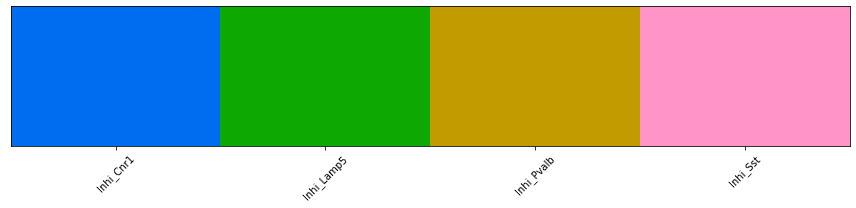

In [144]:
# Check color legend
curr_cell_type = [] 
for cell_type in sdata.uns['cell_type_order']:
    if cell_type in sdata.obs['cell_type'].unique():
        curr_cell_type.append(cell_type)

        
#sub_cpl = ['#ff7070', '#ffb870', '#fbff00', '#91ff00', '#70fffd', '#0084ff', '#9500ff', '#910000'] # current ex neurons 
# sub_cpl = ['#ffa600', '#69f200', '#fff824', '#0062ff', '#8c00f0', '#f2402c', '#00d8f0', '#006b0e']
sub_cpl = ['#006cf0', '#0da802', '#c29b00', '#ff94c9'] # current inhi neurons 

# sub_cpl = []
# for i in curr_cell_type:
#     if '/' in i:
#         curr_key = i.split('/')
#         sub_cpl.append(sdata.uns['sub_hex_dict'][curr_key[0]][curr_key[1]])
#     else:       
#         sub_cpl.append(sdata.uns['sub_hex_dict'][i])

sub_cpl = sns.color_palette(sub_cpl)
sub_cmap = ListedColormap(sub_cpl.as_hex())
sns.palplot(sub_cpl, size=3)
plt.xticks(range(len(curr_cell_type)), curr_cell_type, size=10, rotation=45)
plt.tight_layout()
plt.show()

In [145]:
# Spatial cell type 
for sample in sorted(sdata.obs['sample'].unique()):
    current_key = f"{sample}_morph"
    current_index = sdata.obs['sample'] == sample
    # change to new color 
    sdata.uns[current_key]['colors'] = sdata.obs.loc[current_index, 'cell_type'].cat.codes.values
    sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
    
    if sample in plot_sample:
        print(sample)
        su.plot_poly_cells_cluster_by_sample(sdata, sample, sub_cmap, show_plaque=True, show_tau=True,
                                             save_as_real_size=True, linewidth=0.5,
                                            figscale=3, width=10, height=10, save=True, show=False)


AD_mouse9494
AD_mouse9498
AD_mouse9723
AD_mouse9735


### Oligo + OPC (Fig. 5)

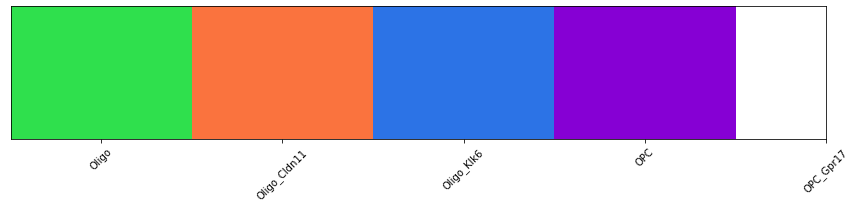

Trying to set attribute `.obs` of view, copying.


AD_mouse9494
AD_mouse9498
AD_mouse9723
AD_mouse9735


In [43]:
# Subset
plot_sample = ['AD_mouse9735', 'AD_mouse9723', 'AD_mouse9498', 'AD_mouse9494']

curr_cells = adata.obs['top_level'].isin(['Oligo', 'OPC'])
sdata = adata[curr_cells, :]

# Check color legend
curr_cell_type = [] 
for cell_type in sdata.uns['cell_type_order']:
    if cell_type in sdata.obs['cell_type'].unique():
        curr_cell_type.append(cell_type)

sub_cpl = []
for i in curr_cell_type:
    if 'OPC' in i:
        pass
    else:
        if '/' in i:
            curr_key = i.split('/')
            sub_cpl.append(sdata.uns['sub_rgb_dict'][curr_key[0]][curr_key[1]])
        else:       
            sub_cpl.append(sdata.uns['sub_rgb_dict'][i])
          
sub_cpl = ['#2fe04d', '#fa733e', '#2c73e6']
sub_cpl.append(sdata.uns['top_rgb_dict']['OPC'])
sub_cpl = sns.color_palette(sub_cpl)
sub_cmap = ListedColormap(sub_cpl.as_hex())
sns.palplot(sub_cpl, size=3)
plt.xticks(range(len(curr_cell_type)), curr_cell_type, size=10, rotation=45)
plt.tight_layout()
# plt.savefig(f'./figures/color_legend_{sub_id}.png')
plt.show()

# Spatial cell type 
for sample in sorted(sdata.obs['sample'].unique()):
    current_key = f"{sample}_morph"
    current_index = sdata.obs['sample'] == sample
    # change to new color 
    sdata.obs['plot_type'] = sdata.obs['cell_type'].astype(object)
    sdata.obs.loc[sdata.obs['top_level'] == 'OPC', 'plot_type'] = 'OPC'
    sdata.obs['plot_type'] = sdata.obs['plot_type'].astype('category')
    sdata.obs['plot_type'] = sdata.obs['plot_type'].cat.reorder_categories(['Oligo', 'Oligo_Cldn11', 'Oligo_Klk6', 'OPC'])
    
    sdata.uns[current_key]['colors'] = sdata.obs.loc[current_index, 'plot_type'].cat.codes.values
    sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
    
    if sample in plot_sample:
        print(sample)
        su.plot_poly_cells_cluster_by_sample(sdata, sample, sub_cmap, show_plaque=True, show_tau=True,
                                             save_as_real_size=True, linewidth=0.5,
                                            figscale=3, width=10, height=10, save=True, show=False)


Trying to set attribute `.obs` of view, copying.


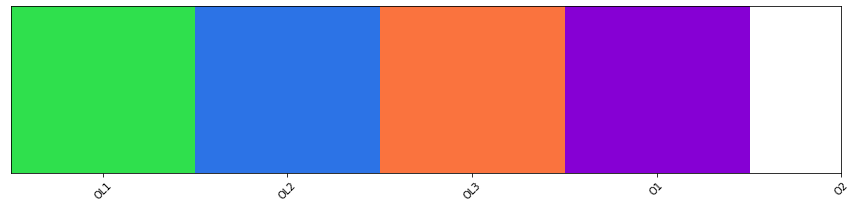

AD_mouse9735
Cortex, AD_mouse9735, 1632600.1251
AD_mouse9723
Cortex, AD_mouse9723, 1926523.4278499999
AD_mouse9498
Cortex, AD_mouse9498, 1726752.3462000003
AD_mouse9494
Cortex, AD_mouse9494, 1458773.99955


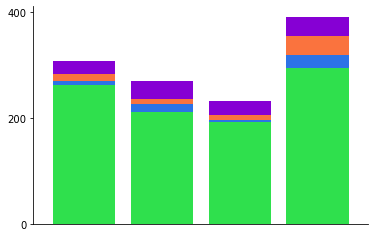

Trying to set attribute `.obs` of view, copying.


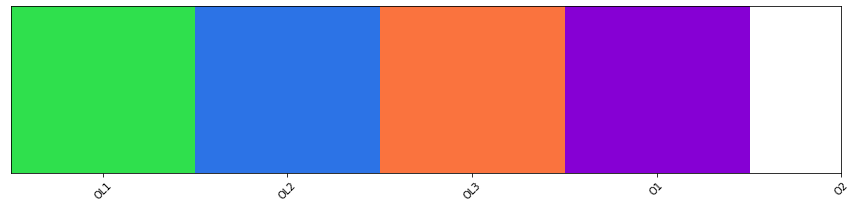

AD_mouse9735
White Matter, AD_mouse9735, 376200.77197500004
AD_mouse9723
White Matter, AD_mouse9723, 328127.1525
AD_mouse9498
White Matter, AD_mouse9498, 294397.99515000003
AD_mouse9494
White Matter, AD_mouse9494, 395177.25555


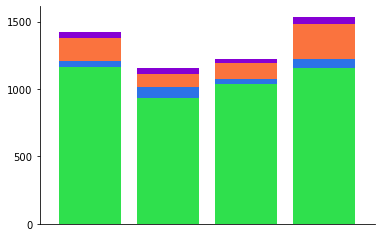

Trying to set attribute `.obs` of view, copying.


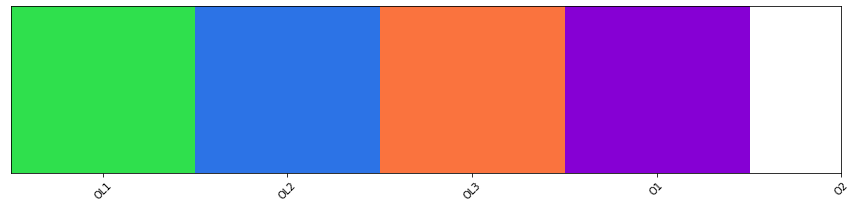

AD_mouse9735
Hippocampus, AD_mouse9735, 1924613.048925
AD_mouse9723
Hippocampus, AD_mouse9723, 1638123.18705
AD_mouse9498
Hippocampus, AD_mouse9498, 1762894.4571
AD_mouse9494
Hippocampus, AD_mouse9494, 2577644.525925


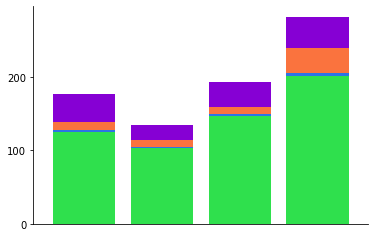

In [46]:
# Subset of regions

all_list = []

region_list = ['Cortex', 'White Matter', 'Hippocampus']
# region_list = ['Cortex', 'Subcortical']

sub_id = 'Oligo'
show_colormap = True

# Iterate region 
for r, current_region in enumerate(region_list):
    
    if current_region == 'Cortex':
        current_index = (adata.obs['region'] == current_region) & (~adata.obs['top_level'].isin(['CA1', 'CA2', 'CA3', 'DG', 'LHb']))
    elif current_region == 'White Matter':
        current_index = (adata.obs['region'] == current_region) & (~adata.obs['top_level'].isin(['Ex', 'Inhi', 'CA1', 'CA2', 'CA3', 'DG', 'LHb']))
    elif current_region == 'Hippocampus':
        current_index = (adata.obs['region'] == current_region) 
    elif current_region == 'Subcortical':
        current_index = (adata.obs['region'].isin(['White Matter', 'Hippocampus'])) & (~adata.obs['top_level'].isin(['Ex']))
    
    # cell type Subset
    rdata = adata[current_index, :]
    curr_cells = rdata.obs['top_level'].isin(['Oligo', 'OPC'])
    sdata = rdata[curr_cells, :]
    sdata.obs['sample'] = sdata.obs['sample'].cat.reorder_categories(['AD_mouse9735', 'AD_mouse9723', 'AD_mouse9498', 'AD_mouse9494'])

    # Check color legend
    curr_cell_type = [] 
    for cell_type in sdata.uns['cell_type_label']:
        if cell_type in sdata.obs['cell_type_label'].unique():
            curr_cell_type.append(cell_type)

#     sub_cpl = []
#     for i in curr_cell_type:
#         if i in ['O1', 'O2']:
#             sub_cpl.append(sdata.uns['top_rgb_dict']['OPC'])
#         else:
#             if '/' in i:
#                 curr_key = i.split('/')
#                 sub_cpl.append(sdata.uns['label_rgb_dict'][curr_key[0]][curr_key[1]])
#             else:       
#                 sub_cpl.append(sdata.uns['label_rgb_dict'][i])

    
#     sub_cpl[1], sub_cpl[2] = sub_cpl[2], sub_cpl[1]
#     sub_cpl = sns.color_palette(sub_cpl)
#     sub_cmap = ListedColormap(sub_cpl.as_hex())
    sub_cpl = ['#2fe04d', '#2c73e6', '#fa733e']
    sub_cpl.append(sdata.uns['top_rgb_dict']['OPC'])
    sub_cpl = sns.color_palette(sub_cpl)
    sub_cmap = ListedColormap(sub_cpl.as_hex())
    if show_colormap:
        sns.palplot(sub_cpl, size=3)
        plt.xticks(range(len(curr_cell_type)), curr_cell_type, size=10, rotation=45)
        plt.tight_layout()
        # plt.savefig(f'./figures/color_legend_{sub_id}.png')
        plt.show()
        
    # normalized barplot
    region_dict = {'Cortex':1, 'White Matter':2, 'Hippocampus':3}
    sample_tags = ['Control (8 months)', 'Disease (8 months)', 'Control (13 months)', 'Disease (13 months)']

    cell_dist_list = []
    for i, sample in enumerate(sdata.obs['sample'].cat.categories):
        print(sample)
        curr_cells = (sdata.obs['sample'] == sample)
        temp = sdata[curr_cells, :]

        cell_dist = pd.DataFrame(temp.obs['cell_type_label'].value_counts())
        cell_dist['counts'] = cell_dist['cell_type_label']
        cell_dist['cell_type_label'] = cell_dist.index
        cell_dist['cell_type_label'] = cell_dist['cell_type_label'].astype(object)
        cell_dist = cell_dist.reset_index(drop=True)
        # cell_dist = cell_dist.loc[cell_dist['counts'] != 0, :]
        # cell_dist['cell_type'] = cell_dist['cell_type'].astype('category')

        for j in curr_cell_type:
            if j not in cell_dist['cell_type_label'].unique():
                cell_dist = cell_dist.append({'cell_type_label': j, 'counts': 0}, ignore_index=True)

        cell_dist['cell_type_label'] = cell_dist['cell_type_label'].astype('category')
        cell_dist['cell_type_label'] = cell_dist['cell_type_label'].cat.reorder_categories(curr_cell_type)
        cell_dist['sample'] = sample_tags[i]
        
        current_area = 0
        for k, region in enumerate(regionprops(sdata.uns[f'{sample}_morph']['region'])):
            if current_region == 'Subcortical':
                if region.label != 1:
                    current_area += region.area * 0.315 * 0.315
            else:
                if region.label == r+1:
                    current_area = region.area * 0.315 * 0.315
                    
        print(f"{current_region}, {sample}, {current_area}")
        
        cell_dist['counts'] = cell_dist['counts'] / current_area * 1000000
        cell_dist['counts'] = cell_dist['counts'].round()
        cell_dist['counts'] = cell_dist['counts'].astype(int)
        cell_dist['region'] = current_region
        cell_dist = cell_dist.reset_index(drop=True)
    
        # print(cell_dist.shape)
        cell_dist_list.append(cell_dist)
        
    cell_dist_total = pd.concat(cell_dist_list)
    cell_dist_total['sample'] = cell_dist_total['sample'].astype('category')
    cell_dist_total['sample'] = cell_dist_total['sample'].cat.reorder_categories(sample_tags)
    cell_dist_total['cell_type_label'] = cell_dist_total['cell_type_label'].cat.reorder_categories(['OL1', 'OL3', 'OL2', 'O1', 'O2'])
    
    df = cell_dist_total.pivot(columns='cell_type_label',index='sample').fillna(0)
    # plot it
    fig, ax = plt.subplots()
    df.plot(kind='bar', stacked=True, legend=False, cmap=sub_cmap, ax=ax, width=0.8)
    #plt.setp(ax.patches, linewidth=1, edgecolor='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    plt.locator_params(axis='y', nbins=4)
    plt.savefig(f'./figures/{sub_id}_{current_region}_composition.pdf')
    plt.show()

In [57]:
# Subset
curr_cells = adata.obs['top_level'].isin(['Oligo', 'OPC'])
sdata = adata[curr_cells, :]
sdata

View of AnnData object with n_obs × n_vars = 5515 × 2112
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', '__is_in_cluster__', 'top_level', 'cell_type', 'region', 'cell_type_label'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells', 'mean', 'std'
    uns: 'AD_mouse9494_morph', 'AD_mouse9498_morph', 'AD_mouse9723_morph', 'AD_mouse9735_morph', 'cell_type_label', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict'
    layers: 'corrected', 'scaled'

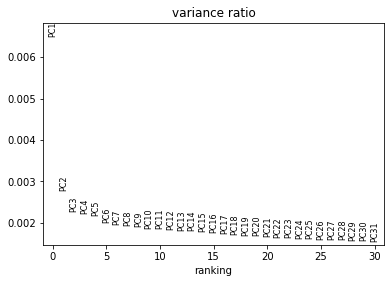

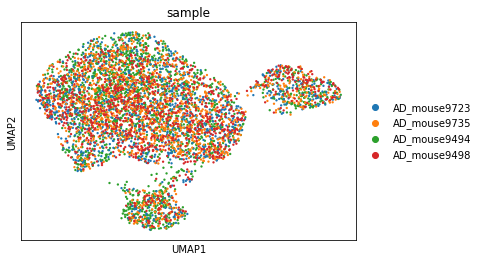

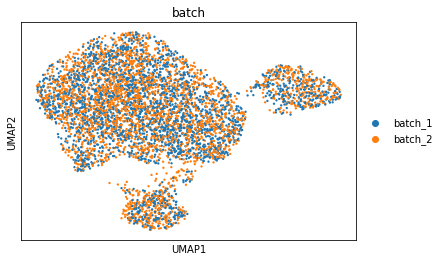

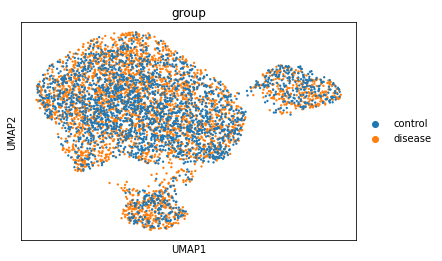

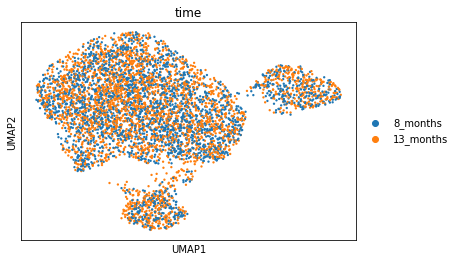

AD_mouse9494


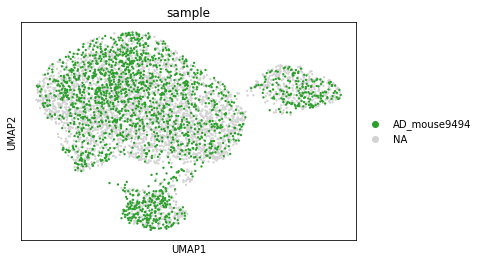

AD_mouse9498


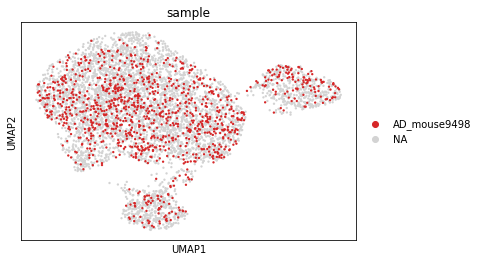

AD_mouse9723


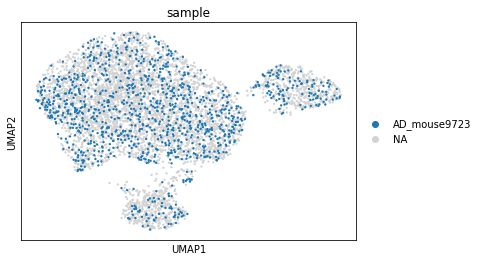

AD_mouse9735


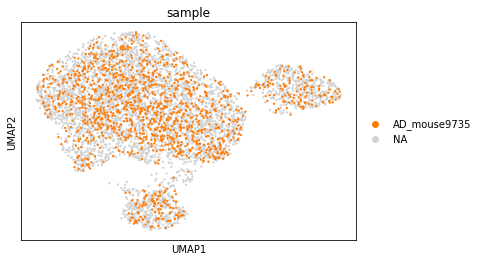

control


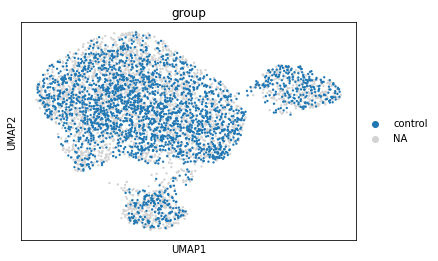

disease


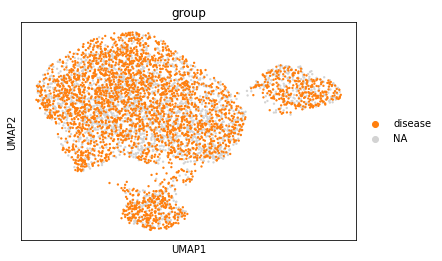

CPU times: user 47.6 s, sys: 3.03 s, total: 50.6 s
Wall time: 21.7 s


In [58]:
%%time
# Run PCA
sc.tl.pca(sdata, svd_solver='arpack')

# Plot explained variance 
sc.pl.pca_variance_ratio(sdata, log=False)

# Computing the neighborhood graph
n_neighbors = 30
n_pcs = 6
cluster_resolution = .3


sc.pp.neighbors(sdata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(sdata)

# Plot UMAP
sc.pl.umap(sdata, color='sample', save='_sample')
sc.pl.umap(sdata, color='batch', save='_batch')
sc.pl.umap(sdata, color='group', save='_group')
sc.pl.umap(sdata, color='time', save='_time')

# Plot sample-wise UMAP
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    sc.pl.umap(sdata, color='sample', groups=sample, save=f'_sample_{sample}')

# Plot group-wise UMAP
for group in sorted(sdata.obs['group'].unique()):
    print(group)
    sc.pl.umap(sdata, color='group', groups=group, save=f'_group_{group}')


# Save log
with open(f'./figures/log.txt', 'w') as f:
    f.write(f"""Number of neighbor: {n_neighbors}
Number of PC: {n_pcs}
Resolution: {cluster_resolution}""")

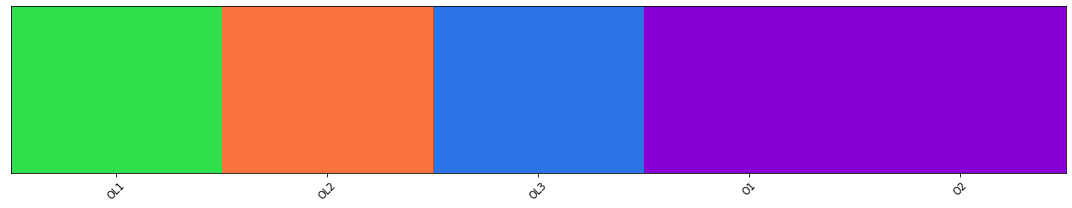

In [61]:
# Check color legend
# curr_cell_type = [] 
# for cell_type in sdata.uns['cell_type_order']:
#     if cell_type in sdata.obs['cell_type'].unique():
#         curr_cell_type.append(cell_type)

# sub_cpl = []
# for i in curr_cell_type:
#     if i in ['OPC', 'OPC_Gpr17']:
#         pass
#     else:
#         if '/' in i:
#             curr_key = i.split('/')
#             sub_cpl.append(sdata.uns['sub_rgb_dict'][curr_key[0]][curr_key[1]])
#         else:       
#             sub_cpl.append(sdata.uns['sub_rgb_dict'][i])
            
sub_cpl = ['#2fe04d', '#fa733e', '#2c73e6']

sub_cpl.append(sdata.uns['top_rgb_dict']['OPC'])
sub_cpl.append(sdata.uns['top_rgb_dict']['OPC'])
sub_cpl = sns.color_palette(sub_cpl)
sub_cmap = ListedColormap(sub_cpl.as_hex())
sns.palplot(sub_cpl, size=3)
plt.xticks(range(len(curr_cell_type)), curr_cell_type, size=10, rotation=45)
plt.tight_layout()
# plt.savefig(f'./figures/color_legend_{sub_id}.png')
plt.show()

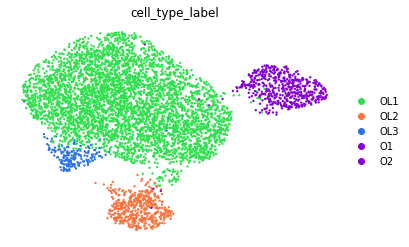

In [62]:
sc.pl.umap(sdata, color='cell_type_label', frameon=False, 
           palette=sub_cpl, save=f'_label')

In [ ]:
gene = 'PDGFRA'
sc.pl.umap(sdata, color=gene, save=f'_{gene}')

Trying to set attribute `.uns` of view, copying.


AD_mouse9494


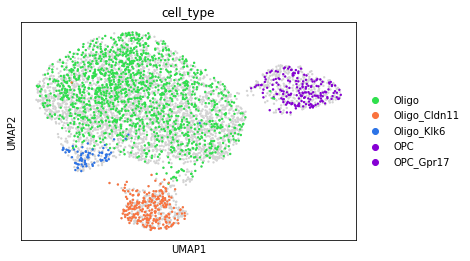

Trying to set attribute `.uns` of view, copying.


AD_mouse9498


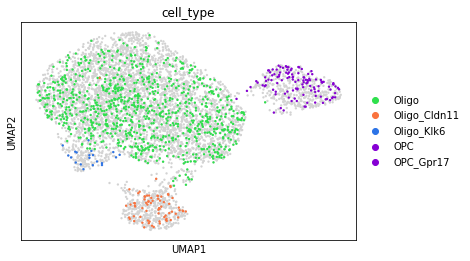

Trying to set attribute `.uns` of view, copying.


AD_mouse9723


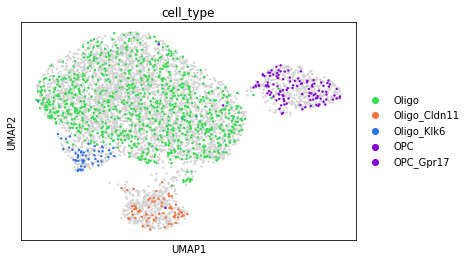

Trying to set attribute `.uns` of view, copying.


AD_mouse9735


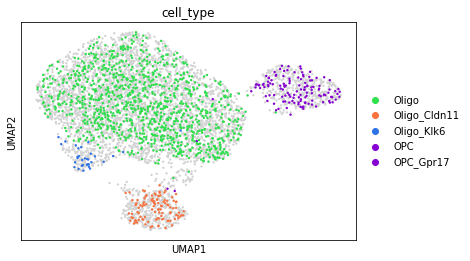

In [63]:
# Plot sample wise UMAP with sub-level labels 
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    ax = sc.pl.umap(sdata, show=False, size=(120000 / sdata.n_obs))
    sc.pl.umap(sdata[sdata.obs["sample"] == sample], color='cell_type', frameon=True, ax=ax, size=(120000 / sdata.n_obs),
               palette=sub_cpl, save=f'_{sample}')


### Gene trend comparison

In [293]:
# Load 2766 dataset 
new_obs = pd.read_csv('./output/2020-12-27-obs.csv', index_col=0)

# Set path
base_path = './'
out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(out_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

expr_path = os.path.join(out_path, 'complete_cell_barcode_count.csv')
var_path = os.path.join(out_path, 'cell_barcode_names.csv')
obs_path = os.path.join(out_path, 'complete_meta.csv')

# add expression data to the AnnData object 
expr_x = np.loadtxt(expr_path, delimiter=',')
var = pd.read_csv(var_path, header=None)
var = pd.DataFrame(index=var.iloc[:,2].to_list())
obs = pd.read_csv(obs_path, index_col=0)

adata = AnnData(X=expr_x, var=var, obs=obs)

adata = adata[new_obs.index, :]
adata.obs = new_obs
adata

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([2, 8], dtype='int64'), …


AnnData object with n_obs × n_vars = 33106 × 2766
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', '__is_in_cluster__', 'top_level', 'cell_type', 'region', 'cell_type_label'

In [5]:
# Load 64 genes validation dataset 
vdata = sc.read_h5ad('../2021-03-20-mAD-64-genes-reads-assignment/output/2021-03-30-starmap-mAD-64-genes-raw.h5ad')
vdata.obs = pd.read_csv('../2021-03-20-mAD-64-genes-reads-assignment/output/2021-04-12-obs.csv', index_col=0)
vdata

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([1, 3], dtype='int64'), …


AnnData object with n_obs × n_vars = 36625 × 64
    obs: 'orig_index', 'sample', 'area', 'tau', 'gfap', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'predicted_top_level', 'predicted_top_level_score', 'predicted_cell_type', 'predicted_cell_type_score', 'predicted_cell_type_label', 'predicted_cell_type_label_score', 'leiden', 'top_level'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells'
    uns: 'AD_mouse9721_morph', 'AD_mouse9781_morph', 'AD_mouse9919_morph', 'AD_mouse9930_morph', 'cell_type_label', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict'

In [295]:
# Nomalization
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.normalize_total(vdata)
sc.pp.log1p(vdata)

In [296]:
gene_annotation = pd.read_csv('./gene_module/genes_annotation.csv')
gene_annotation

adata.obs['tag'] = adata.obs['time'].astype(str) + '_' + adata.obs['group'].astype(str) + '_2766'
adata.obs['tag'] = adata.obs['tag'].astype('category')
adata.obs['tag'] = adata.obs['tag'].cat.reorder_categories(['8_months_control_2766', '8_months_disease_2766', 
                                                            '13_months_control_2766', '13_months_disease_2766'])

vdata.obs['tag'] = vdata.obs['time'].astype(str) + '_' + vdata.obs['group'].astype(str) + '_64'
vdata.obs['tag'] = vdata.obs['tag'].astype('category')
vdata.obs['tag'] = vdata.obs['tag'].cat.reorder_categories(['8_months_control_64', '8_months_disease_64', 
                                                            '13_months_control_64', '13_months_disease_64'])

adata.obs.index = adata.obs.index.astype(str)
vdata.obs.index = vdata.obs.index.astype(str)

In [297]:
# Subset

sub_id = ['Astro']

curr_cells = adata.obs['top_level'].isin(sub_id)
sdata_2766 = adata[curr_cells, :]
sdata_2766

curr_cells = vdata.obs['top_level'].isin(sub_id)
sdata_64 = vdata[curr_cells, :]
sdata_64

View of AnnData object with n_obs × n_vars = 3423 × 64
    obs: 'orig_index', 'sample', 'area', 'tau', 'gfap', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'predicted_top_level', 'predicted_top_level_score', 'predicted_cell_type', 'predicted_cell_type_score', 'predicted_cell_type_label', 'predicted_cell_type_label_score', 'leiden', 'top_level', 'tag'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells'
    uns: 'AD_mouse9721_morph', 'AD_mouse9781_morph', 'AD_mouse9919_morph', 'AD_mouse9930_morph', 'cell_type_label', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict', 'log1p'

In [298]:
# Get genes
genes = gene_annotation.loc[gene_annotation['top_level'].isin(sub_id), 'Gene'].to_list()

final_genes = genes # + ['CD9']

Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'time' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'top_level' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'region' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_label' as categorical


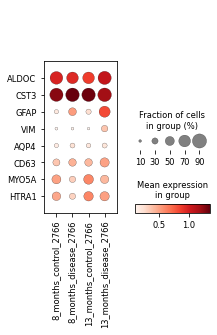

In [299]:
# Plot 2766
sc.pl.dotplot(sdata_2766, final_genes, groupby='tag', swap_axes=True)

Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'time' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'predicted_top_level' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'predicted_cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'predicted_cell_type_label' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'top_level' as categorical


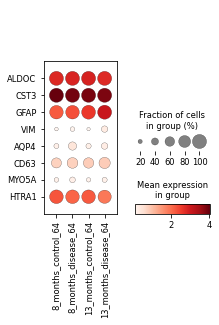

In [300]:
# Plot 64
sc.pl.dotplot(sdata_64, final_genes, groupby='tag', swap_axes=True)

In [301]:
# Combine sdatas 

sdata_combined = sdata_2766.concatenate(sdata_64)
sdata_combined

AnnData object with n_obs × n_vars = 6307 × 64
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', '__is_in_cluster__', 'top_level', 'cell_type', 'region', 'cell_type_label', 'tag', 'gfap', 'predicted_top_level', 'predicted_top_level_score', 'predicted_cell_type', 'predicted_cell_type_score', 'predicted_cell_type_label', 'predicted_cell_type_label_score'
    var: 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'max_counts-1', 'n_cells-1'

In [302]:
# Reorder tag

sdata_combined.obs['tag'] = sdata_combined.obs['tag'].astype('category')
sdata_combined.obs['tag'] = sdata_combined.obs['tag'].cat.reorder_categories(['8_months_control_2766', '8_months_disease_2766', 
                                                            '13_months_control_2766', '13_months_disease_2766',
                                                              '8_months_control_64', '8_months_disease_64', 
                                                            '13_months_control_64', '13_months_disease_64'])

... storing 'sample' as categorical
... storing '__is_in_cluster__' as categorical
... storing 'cell_type' as categorical
... storing 'region' as categorical
... storing 'cell_type_label' as categorical
... storing 'predicted_top_level' as categorical
... storing 'predicted_cell_type' as categorical
... storing 'predicted_cell_type_label' as categorical


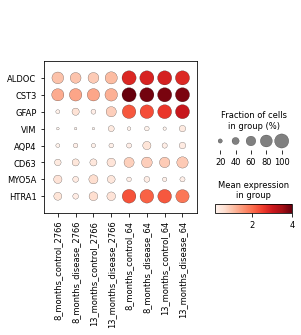

In [303]:
# Plot 64
sc.pl.dotplot(sdata_combined, final_genes, groupby='tag', swap_axes=True, save=f'Micro_DEG')

### DG subclustering

In [17]:
# Subset
sub_id = 'DG'
curr_cells = (adata.obs['top_level'] == sub_id) & (adata.obs['time'] == '13_months')
sdata = adata[curr_cells, :]
sdata

View of AnnData object with n_obs × n_vars = 3163 × 2112
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', '__is_in_cluster__', 'top_level', 'cell_type', 'region', 'cell_type_label'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells', 'mean', 'std'
    uns: 'AD_mouse9494_morph', 'AD_mouse9498_morph', 'AD_mouse9723_morph', 'AD_mouse9735_morph', 'cell_type_label', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict'
    layers: 'corrected', 'scaled'

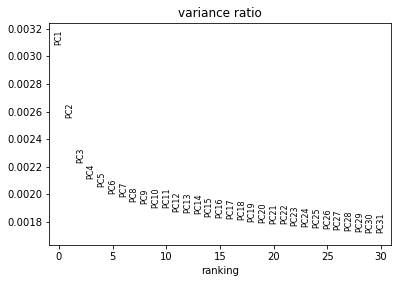

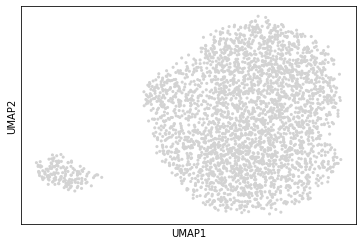

CPU times: user 19.7 s, sys: 1.15 s, total: 20.8 s
Wall time: 7.35 s


In [23]:
%%time
# Run PCA
sc.tl.pca(sdata, svd_solver='arpack')

# Plot explained variance 
sc.pl.pca_variance_ratio(sdata, log=False)

# Computing the neighborhood graph
n_neighbors = 30
n_pcs = 10

sc.pp.neighbors(sdata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(sdata)
sc.pl.umap(sdata)

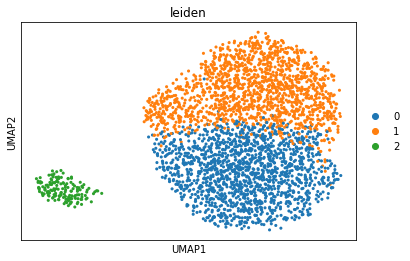

In [28]:
# Clustering
cluster_resolution = .4

sc.tl.leiden(sdata, resolution=cluster_resolution)
sc.pl.umap(sdata, color='leiden')

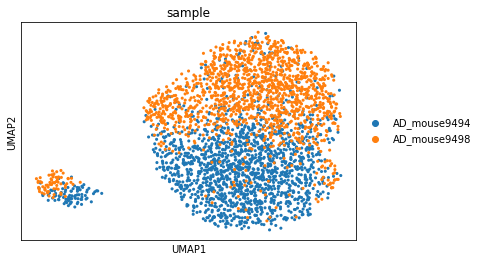

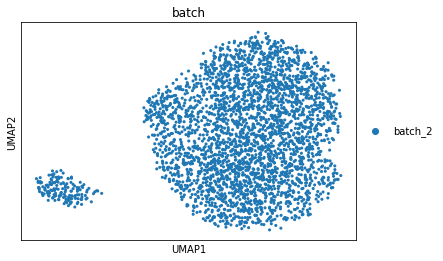

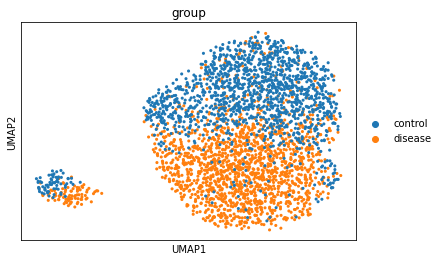

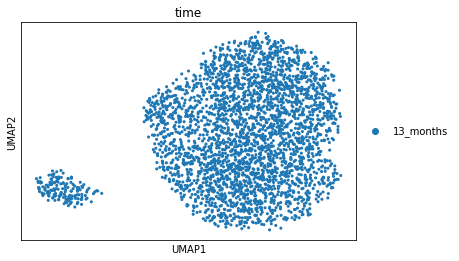

AD_mouse9494


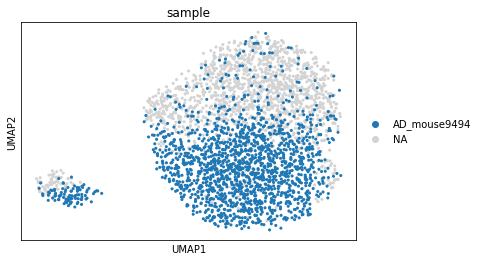

AD_mouse9498


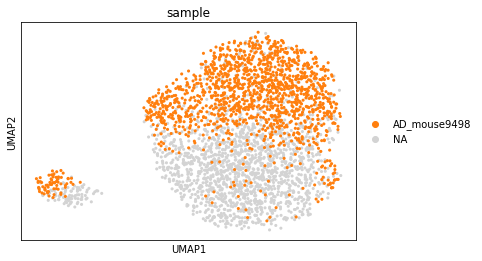

control


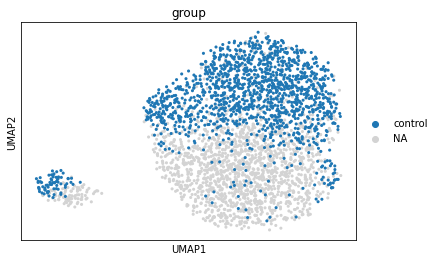

disease


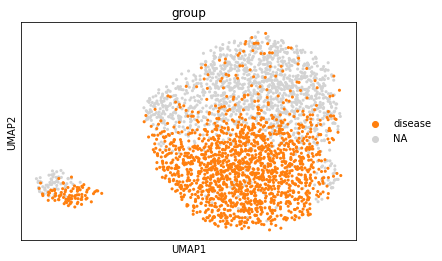

In [26]:
# Plot UMAP
sc.pl.umap(sdata, color='sample')
sc.pl.umap(sdata, color='batch')
sc.pl.umap(sdata, color='group')
sc.pl.umap(sdata, color='time')

# Plot sample-wise UMAP
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    sc.pl.umap(sdata, color='sample', groups=sample, save=False)

# Plot group-wise UMAP
for group in sorted(sdata.obs['group'].unique()):
    print(group)
    sc.pl.umap(sdata, color='group', groups=group, save=False)


# Save log
with open(f'./figures/log.txt', 'w') as f:
    f.write(f"""Number of neighbor: {n_neighbors}
Number of PC: {n_pcs}""")

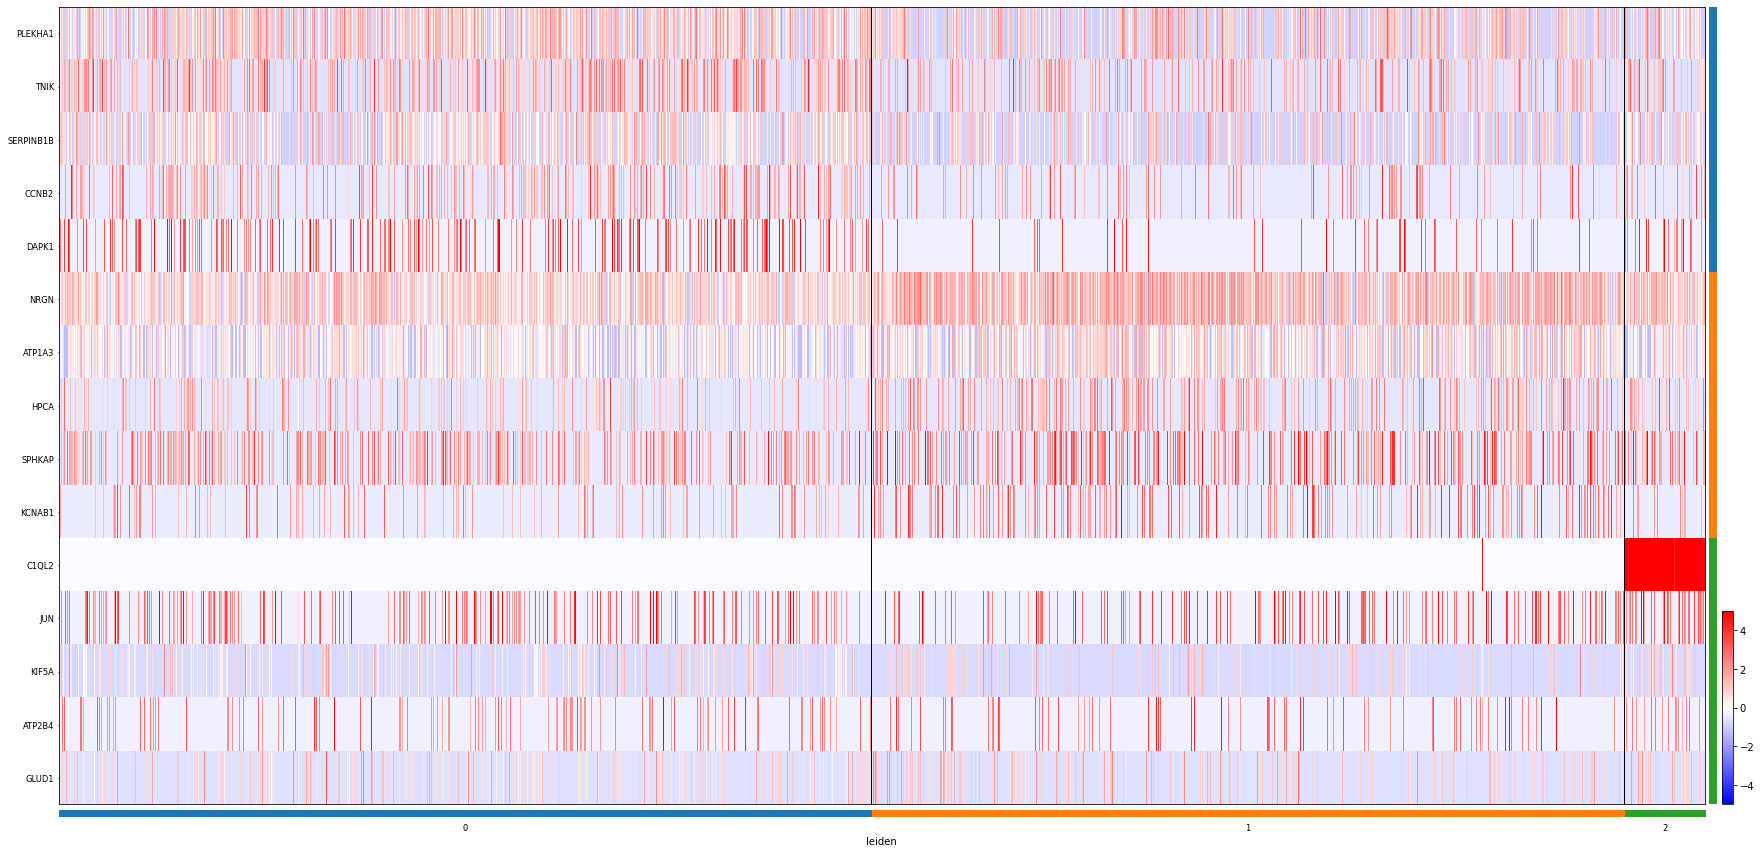

0 ['PLEKHA1', 'TNIK']
1 ['NRGN', 'ATP1A3']
2 ['C1QL2', 'ATP2B3']


In [29]:
# Find gene markers for each cluster
sc.tl.rank_genes_groups(sdata, 'leiden', method='wilcoxon')

min_logfoldchange = .5
# # Plot logFC heatmap
# sc.pl.rank_genes_groups_heatmap(sdata, n_genes=5, groupby='cell_type', min_logfoldchange=min_logfoldchange, use_raw=False, swap_axes=True, 
#                                 vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True, values_to_plot='logfoldchanges',
#                                 dendrogram=False, figsize=(30, 15), save='_logFC')

# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(sdata, n_genes=5, groupby='leiden', min_logfoldchange=min_logfoldchange, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save='_zscore')

# # Plot logFC dotplot
# sc.pl.rank_genes_groups_dotplot(sdata, n_genes=5, groupby='cell_type', values_to_plot='logfoldchanges', min_logfoldchange=min_logfoldchange, 
#                                 vmax=5, vmin=-5, cmap='bwr', save='logFC')

# # Plot expression violin plot
# sc.pl.rank_genes_groups_stacked_violin(sdata, n_genes=5, groupby='cell_type', min_logfoldchange=min_logfoldchange, 
#                                        cmap='viridis_r', save=sub_id)

# # Plot expression violin plot
# sc.pl.rank_genes_groups_stacked_violin(sdata, n_genes=5, groupby='cell_type', min_logfoldchange=min_logfoldchange, 
#                                        cmap='viridis_r', dendrogram=False, save=f'{sub_id}_noden')

# # Plot expression matrix plot
# sc.pl.rank_genes_groups_matrixplot(sdata, n_genes=5, use_raw=False, vmin=-5, vmax=5, cmap='bwr', layer='scaled',
#                                   dendrogram=False, min_logfoldchange=min_logfoldchange, save=sub_id)

# Print markers 
markers = []
temp = pd.DataFrame(sdata.uns['rank_genes_groups']['names']).head(2)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)
    
# print(markers)
# plt.figure(figsize=(20,10))
# su.plot_heatmap_with_labels(adata, markers, 'leiden', use_labels=top_level_order,
#                             cmap=cluster_cmap, show_axis=True, font_size=10)
# plt.savefig('./figures/heatmap_top_v2.pdf')

In [33]:
pd.DataFrame(sdata.uns['rank_genes_groups']['names'])

0          1        2
0       PLEKHA1       NRGN    C1QL2
1          TNIK     ATP1A3   ATP2B3
2     SERPINB1B     TMSB4X     ANO3
3         CCNB2        NSF   RBFOX1
4         DAPK1      CALM1      JUN
...         ...        ...      ...
2107       HPCA      CCNB2    CALM1
2108        NSF       TNIK     DAB1
2109     TMSB4X  SERPINB1B  SIPA1L1
2110     ATP1A3      DAPK1    SRRM2
2111       NRGN    PLEKHA1   CNKSR2

[2112 rows x 3 columns]

In [34]:
pd.DataFrame(sdata.uns['rank_genes_groups']['logfoldchanges'])

0         1          2
0     0.593902  0.705667  12.888355
1     0.769886  0.516128   0.479136
2     0.582346  0.376437   0.400007
3     1.265548  0.496683   0.300652
4     1.878994  0.299950   0.506788
...        ...       ...        ...
2107 -0.986008 -1.269386  -0.106650
2108 -0.528178 -0.754351  -0.343459
2109 -0.370131 -0.611422  -0.499670
2110 -0.512101 -2.123145  -0.258724
2111 -0.686846 -0.609087  -0.434646

[2112 rows x 3 columns]

In [32]:
sdata.uns['rank_genes_groups']['logfoldchanges']

rec.array([( 0.5939017 ,  0.70566726, 12.888355  ),
           ( 0.76988584,  0.51612777,  0.47913602),
           ( 0.58234584,  0.37643707,  0.40000722), ...,
           (-0.37013072, -0.61142194, -0.49967015),
           (-0.51210093, -2.1231453 , -0.25872388),
           (-0.68684584, -0.6090871 , -0.43464574)],
          dtype=[('0', '<f4'), ('1', '<f4'), ('2', '<f4')])

In [ ]:
temp = pd.DataFrame(sdata.uns['rank_genes_groups']['names']).head(2)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)

### PAGA test

In [56]:
# Subset
sub_id = 'Astro'
curr_cells = adata.obs['top_level'] == sub_id
sdata = adata[curr_cells, :]
sdata

View of AnnData object with n_obs × n_vars = 2884 × 2112
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', '__is_in_cluster__', 'top_level', 'cell_type', 'region', 'cell_type_label'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells', 'mean', 'std'
    uns: 'AD_mouse9494_morph', 'AD_mouse9498_morph', 'AD_mouse9723_morph', 'AD_mouse9735_morph', 'cell_type_label', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict', 'pca', 'neighbors', 'umap', 'draw_graph', 'top_level_colors', 'paga', 'top_level_sizes'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa'
    varm: 'PCs'
    layers: 'corrected', 'scaled'
    obsp: 'distances', 'connectivities'

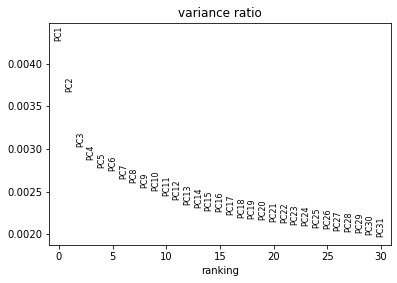

In [57]:
# Run PCA
sc.tl.pca(sdata, svd_solver='arpack')

# Plot explained variance 
sc.pl.pca_variance_ratio(sdata, log=False)

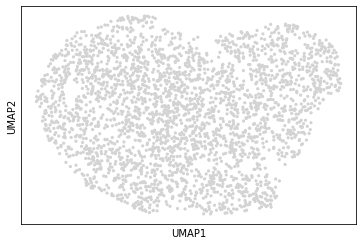

CPU times: user 8.8 s, sys: 674 ms, total: 9.47 s
Wall time: 5.47 s


In [58]:
%%time
# Computing the neighborhood graph
n_neighbors = 30
n_pcs = 3


sc.pp.neighbors(sdata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(sdata)
sc.pl.umap(sdata)

In [69]:
sc.tl.leiden(sdata, resolution=.1)

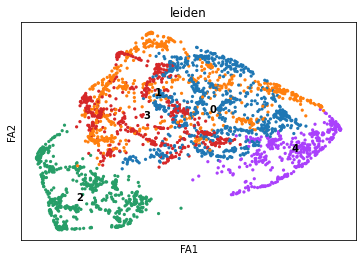

In [70]:
sc.tl.draw_graph(sdata)
sc.pl.draw_graph(sdata, color='leiden', legend_loc='on data')

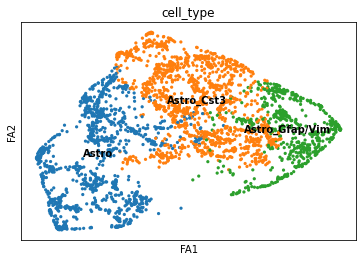

In [60]:
# Denoise option
sc.tl.diffmap(sdata)
sc.pp.neighbors(sdata, n_neighbors=30, use_rep='X_diffmap')

sc.tl.draw_graph(sdata)
sc.pl.draw_graph(sdata, color='cell_type', legend_loc='on data')

In [61]:
sc.tl.paga(sdata, groups='cell_type')

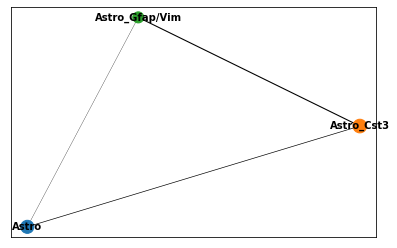

In [62]:
sc.pl.paga(sdata, color='cell_type')

In [63]:
sc.tl.draw_graph(sdata, init_pos='paga')

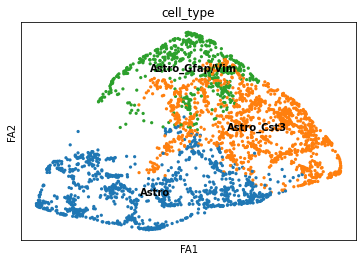

In [64]:
sc.pl.draw_graph(sdata, color=['cell_type'], legend_loc='on data')

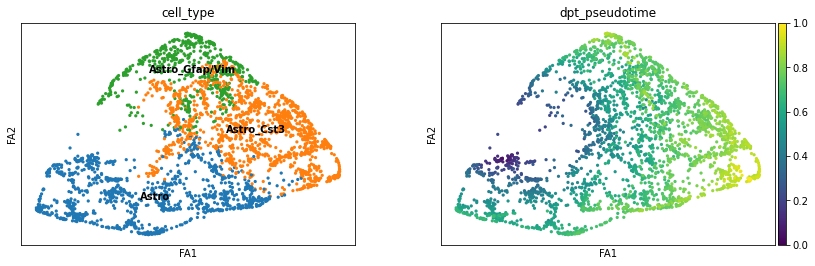

In [65]:
sdata.uns['iroot'] = np.flatnonzero(sdata.obs['cell_type']  == sub_id)[0]
sc.tl.dpt(sdata)
sc.pl.draw_graph(sdata, color=['cell_type', 'dpt_pseudotime'], legend_loc='on data')

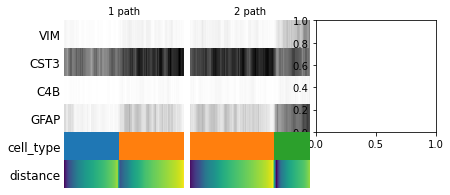

In [66]:
sdata.obs['distance'] = sdata.obs['dpt_pseudotime']
paths = [('1', ['Astro', 'Astro_Cst3']), ('2', ['Astro_Cst3', 'Astro_Gfap/Vim'])]
gene_names = ['VIM', 'CST3', 'C4B', 'GFAP']
_, axs = plt.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        sdata, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='cell_type',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    # data.to_csv('./write/paga_path_{}.csv'.format(descr))
# pl.savefig('./figures/paga_path_paul15.pdf')
plt.show()

### DEG heatmap

In [141]:
sub_id = 'Astro'
deg_df_8 = pd.read_excel(f'deg/{sub_id}.xlsx', sheet_name='Sheet1')
deg_df_13 = pd.read_excel(f'deg/{sub_id}.xlsx', sheet_name='Sheet2')

In [142]:
deg_df_8['abs_logFC'] = deg_df_8['avg_logFC'].abs()
deg_df_8 = deg_df_8.loc[(deg_df_8['abs_logFC'] > 0.1) & (deg_df_8['p_val_adj'] < 0.05), ]
deg_df_8 = deg_df_8.sort_values('avg_logFC', ascending=False)
deg_df_8

Gene         p_val  avg_logFC  pct.AD  pct.ctrl     p_val_adj  \
0      GFAP  4.589571e-29   0.666183   0.411     0.182  1.269475e-25   
4     GPM6A  2.469174e-13   0.266744   0.665     0.611  6.829736e-10   
10      CPE  8.519820e-07   0.206620   0.442     0.403  2.356582e-03   
15     CD63  6.682522e-06   0.196428   0.396     0.358  1.848386e-02   
11      UBC  1.143603e-06   0.175835   0.318     0.247  3.163206e-03   
17     DBN1  9.863393e-06   0.165682   0.261     0.191  2.728215e-02   
12     CNN3  2.421730e-06   0.163085   0.162     0.090  6.698506e-03   
13  GPR37L1  2.651667e-06   0.149965   0.371     0.305  7.334511e-03   
9     TTYH1  2.825939e-07   0.114268   0.591     0.584  7.816547e-04   
6     PTPRS  1.042878e-08  -0.161413   0.066     0.181  2.884601e-05   
7   SPARCL1  3.170920e-08  -0.196309   0.122     0.269  8.770765e-05   
3     AGAP2  4.192777e-14  -0.257043   0.063     0.220  1.159722e-10   
16    MYO5A  7.206658e-06  -0.271074   0.310     0.495  1.993362e-02   
14   TSPAN7  4.790156e-06  -0.273421   0.755     0.877  1.324957e-02   
1      JPH4  4.053444e-16  -0.288285   0.071     0.252  1.121183e-12   
5     CALM1  6.417113e-13  -0.307981   0.159     0.368  1.774973e-09   
8     GPM6B  6.881746e-08  -0.313558   0.281     0.479  1.903491e-04   
2    GABBR2  3.073874e-15  -0.332163   0.140     0.363  8.502334e-12   

    abs_logFC  
0    0.666183  
4    0.266744  
10   0.206620  
15   0.196428  
11   0.175835  
17   0.165682  
12   0.163085  
13   0.149965  
9    0.114268  
6    0.161413  
7    0.196309  
3    0.257043  
16   0.271074  
14   0.273421  
1    0.288285  
5    0.307981  
8    0.313558  
2    0.332163

In [143]:
deg_df_13['abs_logFC'] = deg_df_13['avg_logFC'].abs()
deg_df_13 = deg_df_13.loc[(deg_df_13['abs_logFC'] > 0.1) & (deg_df_13['p_val_adj'] < 0.05), ]
deg_df_13 = deg_df_13.sort_values('avg_logFC', ascending=False)
deg_df_13

Gene         p_val  avg_logFC  pct.AD  pct.ctrl     p_val_adj  \
0        GFAP  1.283869e-50   0.923559   0.650     0.242  3.551182e-47   
1         VIM  4.103294e-22   0.662344   0.321     0.098  1.134971e-18   
14        CLU  4.191935e-10   0.408154   0.614     0.388  1.159489e-06   
10      FXYD1  8.656667e-12   0.361488   0.442     0.230  2.394434e-08   
3        JPH4  3.879352e-19   0.343877   0.388     0.141  1.073029e-15   
29       CTSB  1.203189e-06   0.312790   0.418     0.257  3.328021e-03   
33    PPP1R9B  7.302932e-06   0.303218   0.452     0.297  2.019991e-02   
9       STAT3  2.934774e-13   0.293559   0.270     0.101  8.117586e-10   
15        CD9  4.346295e-10   0.262767   0.341     0.165  1.202185e-06   
18       CNN3  1.879201e-08   0.204675   0.264     0.122  5.197869e-05   
28        MBP  5.159986e-07   0.200698   0.205     0.099  1.427252e-03   
20   TMEM176B  5.483244e-08   0.177961   0.244     0.111  1.516665e-04   
21      PLCE1  5.862793e-08   0.172520   0.151     0.055  1.621648e-04   
30     IGFBP5  1.224977e-06   0.149363   0.245     0.127  3.388286e-03   
22      CCNB2  1.000554e-07   0.145418   0.170     0.067  2.767531e-04   
34     PDLIM4  7.426065e-06   0.127883   0.179     0.086  2.054050e-02   
35     SLC2A3  9.563303e-06   0.127244   0.188     0.093  2.645210e-02   
31        A2M  2.476150e-06   0.122163   0.142     0.058  6.849031e-03   
19        C4B  4.792280e-08   0.116521   0.115     0.033  1.325545e-04   
27      GGTA1  4.371714e-07   0.106901   0.107     0.033  1.209216e-03   
32     SLC6A1  5.597763e-06  -0.146794   0.192     0.256  1.548341e-02   
11      TTYH1  2.998303e-11  -0.163549   0.573     0.638  8.293306e-08   
12  HNRNPA2B1  1.714496e-10  -0.169153   0.412     0.492  4.742295e-07   
23      CALM1  1.192249e-07  -0.173901   0.397     0.444  3.297762e-04   
17    HNRNPA3  2.281474e-09  -0.177226   0.298     0.383  6.310558e-06   
24      HTRA1  1.924771e-07  -0.196302   0.519     0.530  5.323917e-04   
26      CPEB4  2.316591e-07  -0.202783   0.329     0.381  6.407690e-04   
13       GLUL  2.264674e-10  -0.204894   0.386     0.467  6.264088e-07   
16      FGFR3  2.188624e-09  -0.231685   0.177     0.274  6.053735e-06   
5       SRRM2  5.772347e-17  -0.264779   0.527     0.624  1.596631e-13   
6       MYO5A  4.827315e-16  -0.275914   0.449     0.556  1.335235e-12   
8      ATP1A3  4.716398e-15  -0.290954   0.361     0.496  1.304556e-11   
7         UBC  9.358089e-16  -0.298316   0.214     0.357  2.588447e-12   
2       NDRG2  2.546747e-19  -0.306044   0.535     0.638  7.044301e-16   
4       S1PR1  4.520348e-17  -0.316203   0.448     0.559  1.250328e-13   

    abs_logFC  
0    0.923559  
1    0.662344  
14   0.408154  
10   0.361488  
3    0.343877  
29   0.312790  
33   0.303218  
9    0.293559  
15   0.262767  
18   0.204675  
28   0.200698  
20   0.177961  
21   0.172520  
30   0.149363  
22   0.145418  
34   0.127883  
35   0.127244  
31   0.122163  
19   0.116521  
27   0.106901  
32   0.146794  
11   0.163549  
12   0.169153  
23   0.173901  
17   0.177226  
24   0.196302  
26   0.202783  
13   0.204894  
16   0.231685  
5    0.264779  
6    0.275914  
8    0.290954  
7    0.298316  
2    0.306044  
4    0.316203

In [145]:
# Subset
curr_cells = adata.obs['top_level'] == sub_id
sdata = adata[curr_cells, :]

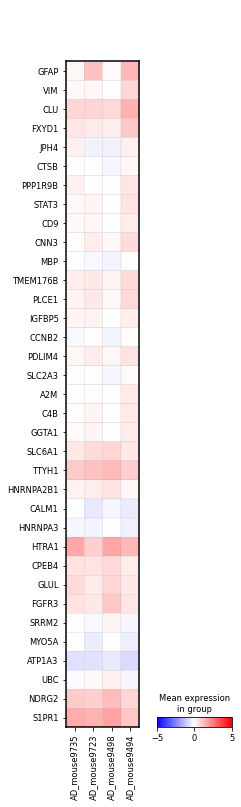

In [146]:
sc.pl.matrixplot(sdata, deg_df_13.Gene, groupby='sample', dendrogram=False,
                      use_raw=False, vmin=-5, vmax=5, cmap='bwr',  swap_axes=True, save=f'{sub_id}')

### Distance Curve fitting

In [513]:
# Load adata
adata = sc.read_h5ad('./output/2021-06-04-starmap-mAD-raw.h5ad')

In [514]:
# Load meta 
meta_8 = pd.read_csv('./spatial/AD9723_cell_meta.csv')
meta_13 = pd.read_csv('./spatial/AD9494_cell_meta.csv')
meta = pd.concat([meta_13])
meta

orig_index     x     y    batch       time    group top_level  \
0               2   905     5  batch_2  13_months  disease        DG   
1               8  2366     7  batch_2  13_months  disease     Astro   
2               9   983     9  batch_2  13_months  disease        DG   
3              11  4057     9  batch_2  13_months  disease       SMC   
4              13  3826     8  batch_2  13_months  disease     Micro   
...           ...   ...   ...      ...        ...      ...       ...   
10016       10736  1526  6650  batch_2  13_months  disease     Micro   
10017       10737  1650  6646  batch_2  13_months  disease     Micro   
10018       10738  3283  6648  batch_2  13_months  disease        Ex   
10019       10740  3731  6641  batch_2  13_months  disease        Ex   
10020       10742  4342  6651  batch_2  13_months  disease        Ex   

             cell_type       region  min_center_dist  min_border_dist  \
0                   DG  Hippocampus       405.635300       391.319490   
1       Astro_Gfap/Vim  Hippocampus       293.626350       275.280614   
2                   DG  Hippocampus       480.505820       466.190010   
3               VLMC_A  Hippocampus      1273.672130      1261.093995   
4      Micro_Cst7/Ctsb  Hippocampus      1104.877680      1087.225066   
...                ...          ...              ...              ...   
10016  Micro_Cst7/Ctsb       Cortex        50.735110        21.000000   
10017            Micro       Cortex        70.956529        28.578919   
10018               L6       Cortex       275.651655       237.077263   
10019       L4/5_RSC_B       Cortex       593.649391       563.074999   
10020       L4/5_RSC_A       Cortex       503.523878       493.418975   

       nearest_plaque  
0                   7  
1                  15  
2                   7  
3                  33  
4                  19  
...               ...  
10016             366  
10017             365  
10018             346  
10019             346  
10020             324  

[10021 rows x 12 columns]

In [515]:
# Preprocessing
adata = adata[:, adata.var.detected]
# sc.pp.normalize_total(adata)
# sc.pp.scale(adata)
adata

View of AnnData object with n_obs × n_vars = 33106 × 2112
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'top_level', 'cell_type', 'region', 'cell_type_label'
    var: 'max_counts', 'detected'
    uns: 'AD_mouse9494_morph', 'AD_mouse9498_morph', 'AD_mouse9723_morph', 'AD_mouse9735_morph', 'cell_type_label_order', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict'

In [516]:
# Subset
sub_id = 'Oligo'
# sample = 'ADmouse_9494'
curr_cells = (adata.obs['top_level'] == sub_id) & (adata.obs['sample'].isin(['AD_mouse9494']))
sdata = adata[curr_cells, :]
sdata

View of AnnData object with n_obs × n_vars = 1722 × 2112
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'top_level', 'cell_type', 'region', 'cell_type_label'
    var: 'max_counts', 'detected'
    uns: 'AD_mouse9494_morph', 'AD_mouse9498_morph', 'AD_mouse9723_morph', 'AD_mouse9735_morph', 'cell_type_label_order', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict'

0.0 10.0
0.0 33.0
0.0 5.0
0.0 4.0
0.0 6.0


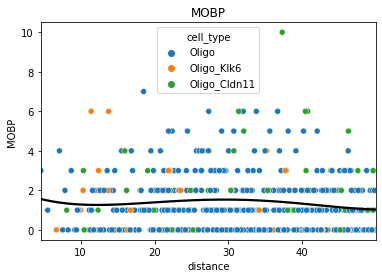

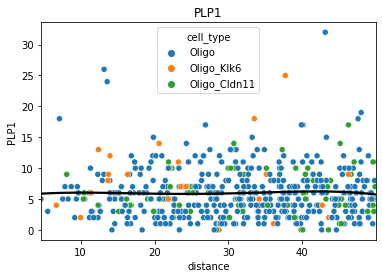

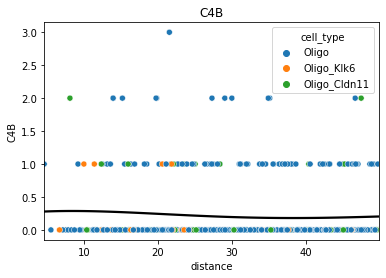

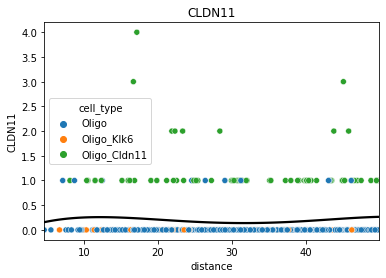

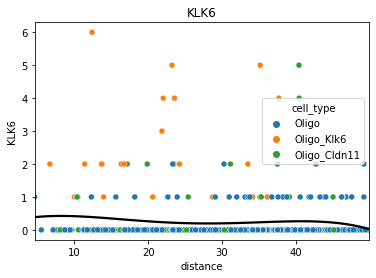

In [523]:
# Construct dataframe
# genes = ['CST7', 'CTSD', 'TREM2', 'CD9']
# genes = ['GFAP', 'VIM', 'AQP4', 'CST3']
genes = ['MOBP', 'PLP1', 'C4B', 'CLDN11', 'KLK6']

df = sdata.obs.copy()
df['distance'] = meta.loc[meta['top_level'] == sub_id, 'min_border_dist'].values
df['distance'] = df['distance'] / 3.3

for gene in genes:
    #current_expr = np.log1p(sdata[:, gene].X.flatten())
    current_expr = sdata[:, gene].X.flatten()
    df[gene] = current_expr
    print(current_expr.min(), current_expr.max())
    
distance_cutoff = 50
for gene in genes:
    current_df = df.loc[df['distance'] < distance_cutoff, ]
    sns.scatterplot(x='distance', y=gene, hue='cell_type', data=current_df)
    sns.regplot(x="distance", y=gene, data=current_df,
                     order=4, ci=None, line_kws={'color': 'k'}, scatter=False)
    plt.title(gene)
    plt.show()
    

In [344]:
sdata = sdata[sdata.obs['distance'] < 333, ]

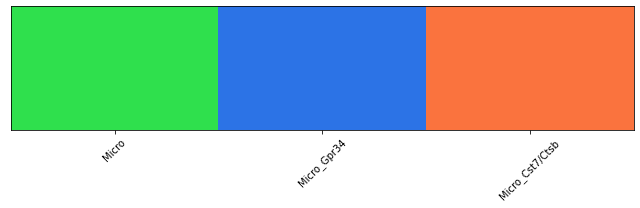

In [387]:
new_color = False

# Check color legend
curr_cell_type = [] 
for cell_type in sdata.uns['cell_type_order']:
    if cell_type in sdata.obs['cell_type'].unique():
        curr_cell_type.append(cell_type)

sub_cpl = []
for i in curr_cell_type:
    if '/' in i:
        curr_key = i.split('/')
        sub_cpl.append(sdata.uns['sub_rgb_dict'][curr_key[0]][curr_key[1]])
    else:       
        sub_cpl.append(sdata.uns['sub_rgb_dict'][i])

if new_color:
    sub_cpl = ['#2fe04d', '#2c73e6', '#fa733e']
sub_cpl = sns.color_palette(sub_cpl)
sub_cmap = ListedColormap(sub_cpl.as_hex())
sns.palplot(sub_cpl, size=3)
plt.xticks(range(len(curr_cell_type)), curr_cell_type, size=10, rotation=45)
plt.tight_layout()
# plt.savefig(f'./figures/color_legend_{sub_id}.png')
plt.show()

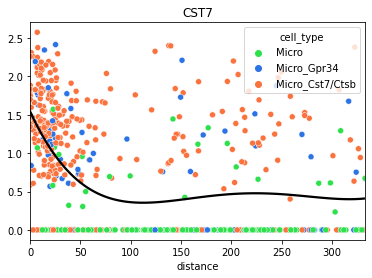

In [389]:
gene = 'CST7'
expr = np.log1p(sdata[:, gene].X.flatten())
sns.scatterplot(x='distance', y=expr, hue='cell_type', data=sdata.obs, palette=sub_cpl)
sns.regplot(x="distance", y=expr, data=sdata.obs,
                 order=4, ci=None, line_kws={'color': 'k'}, scatter=False)
plt.title(gene)
plt.show()

<AxesSubplot:xlabel='distance'>

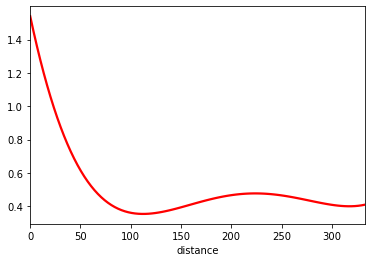

In [381]:
sns.regplot(x="distance", y=expr, data=sdata.obs,
                 order=4, ci=None, line_kws={'color': 'r'}, scatter=False)

<AxesSubplot:xlabel='distance', ylabel='expr'>

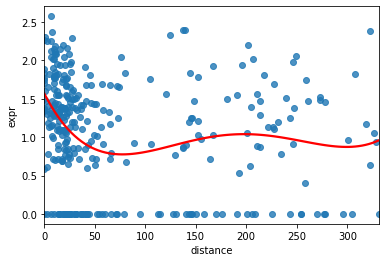

In [353]:
df = sdata.obs
df['expr'] = expr.toarray()
df = df.loc[df['cell_type'] == 'Micro_Cst7/Ctsb', ]
sns.regplot(x="distance", y='expr', data=df, 
                 order=, ci=None, line_kws={'color': 'r'})

<AxesSubplot:xlabel='distance', ylabel='expr'>

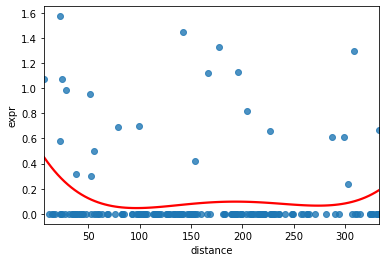

In [354]:
df = sdata.obs
df['expr'] = expr.toarray()
df = df.loc[df['cell_type'] == 'Micro', ]
sns.regplot(x="distance", y='expr', data=df, 
                 order=4, ci=None, line_kws={'color': 'r'})

<AxesSubplot:xlabel='distance', ylabel='expr'>

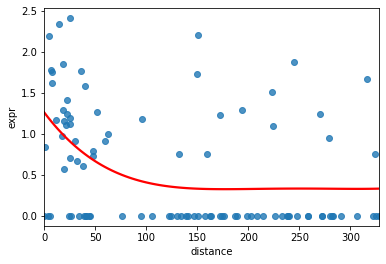

In [355]:
df = sdata.obs
df['expr'] = expr.toarray()
df = df.loc[df['cell_type'] == 'Micro_Gpr34', ]
sns.regplot(x="distance", y='expr', data=df, 
                 order=4, ci=None, line_kws={'color': 'r'})

In [267]:
# define the true objective function
def objective(x, a, b, c, d, e, f):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f
 
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/longley.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
# choose the input and output variables
x, y = data[:, 4], data[:, -1]
# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c, d, e, f = popt
# plot input vs output
pyplot.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d, e, f)
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red')
pyplot.show()

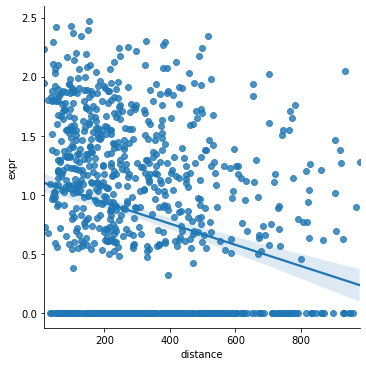

In [268]:
sns.lmplot(x="distance", y='expr',  data=df, lowess=False, robust=False)

## Test

In [267]:
# Load 2766 dataset 
new_obs = pd.read_csv('./output/2020-12-27-obs.csv', index_col=0)

# Set path
base_path = './'
out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(out_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

expr_path = os.path.join(out_path, 'complete_cell_barcode_count.csv')
var_path = os.path.join(out_path, 'cell_barcode_names.csv')
obs_path = os.path.join(out_path, 'complete_meta.csv')

# add expression data to the AnnData object 
expr_x = np.loadtxt(expr_path, delimiter=',')
var = pd.read_csv(var_path, header=None)
var = pd.DataFrame(index=var.iloc[:,2].to_list())
obs = pd.read_csv(obs_path, index_col=0)

adata = AnnData(X=expr_x, var=var, obs=obs)

adata = adata[new_obs.index, :]
adata.obs = new_obs
adata

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([2, 8], dtype='int64'), …


AnnData object with n_obs × n_vars = 33106 × 2766
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', '__is_in_cluster__', 'top_level', 'cell_type', 'region', 'cell_type_label'

In [268]:
# Change obs
rdata = sc.read_h5ad('./output/2020-12-27-starmap-mAD-scaled.h5ad')
adata.obs = rdata.obs

In [269]:
# Change var
adata.var['max_counts'] = adata.X.max(axis=0)
adata.var['highly_variable'] = adata.var['max_counts'] > 2

In [270]:
# Change uns 

adata.uns['cell_type_label'] = rdata.uns['cell_type_label']
adata.uns['cell_type_order'] = rdata.uns['cell_type_order']
adata.uns['label_hex_dict'] = rdata.uns['label_hex_dict']
adata.uns['label_rgb_dict'] = rdata.uns['label_rgb_dict']
adata.uns['sub_hex_dict'] = rdata.uns['sub_hex_dict']
adata.uns['sub_rgb_dict'] = rdata.uns['sub_rgb_dict']
adata.uns['top_hex_dict'] = rdata.uns['top_hex_dict']
adata.uns['top_level_order'] = rdata.uns['top_level_order']
adata.uns['top_rgb_dict'] = rdata.uns['top_rgb_dict']

In [271]:
# Load data and store the information to uns (use scaled version to save computational time)
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    # Load segmentation
    current_seg_path = os.path.join(sample, 'scaled/labeled_cells.tif')
    current_img = tifffile.imread(current_seg_path)
    
    # Load plaque image
    current_plaque_path = os.path.join(sample, 'scaled/plaque.tif')
    current_plaque = tifffile.imread(current_plaque_path)
    # uniform manual threshold 
    current_plaque = gaussian(current_plaque.astype(np.float), 2) > 30
    # current_plaque = remove_small_objects(current_plaque, min_size=64, connectivity=4)
    
    # Load tau image
    current_tau_path = os.path.join(sample, 'scaled/tau_mask.tif')
    current_tau = tifffile.imread(current_tau_path)

    # Store the images to adata object
    current_key = f"{sample}_morph"
    adata.uns[current_key] = {}
    adata.uns[current_key]['label_img'] = current_img
    adata.uns[current_key]['plaque'] = current_plaque
    adata.uns[current_key]['tau'] = current_tau

AD_mouse9494
AD_mouse9498
AD_mouse9723
AD_mouse9735


In [272]:
# Add tau information 
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    labels = adata.uns[current_key]['label_img']
    tau = adata.uns[current_key]['tau'] > 1
    current_index = adata.obs.loc[adata.obs['sample'] == sample, 'orig_index'].values
    tau_intensity = []
    for i, region in enumerate(regionprops(labels)):
        # print(region.label)
        if i in current_index:
            # tau intensity
            curr_intensity = np.sum(tau[region.coords[:, 0], region.coords[:, 1]])
            curr_intensity = curr_intensity / region.area * 100
            tau_intensity.append(round(curr_intensity, 2))
    adata.obs.loc[adata.obs['sample'] == sample, 'tau'] = tau_intensity

AD_mouse9494
AD_mouse9498
AD_mouse9723
AD_mouse9735


In [273]:
adata.write_h5ad('./output/2021-04-22-starmap-mAD-raw.h5ad')

In [274]:
# Normalization scaling
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata.layers['norm'] = adata.X
adata.raw = adata

In [275]:
# Scale data to unit variance and zero mean
sc.pp.scale(adata)
adata.layers['scaled'] = adata.X

# Batch correction
sc.pp.combat(adata)
adata.layers['corrected'] = adata.X

In [276]:
adata.write_h5ad('./output/2021-04-22-starmap-mAD-scaled.h5ad')